In [1]:
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ray import tune

from learning_lidar.utils import vis_utils

sns.set_palette(sns.color_palette("tab10"))

plt.rcParams['figure.dpi'] = vis_utils.FIGURE_DPI
plt.rcParams['savefig.dpi'] = vis_utils.SAVEFIG_DPI

sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('text', usetex=False)
#plt.rc('font', family='serif')
#plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [2]:
def extract_powers(row, in_channels):
    powers = eval(row['powers']) if type(row['powers'])==str else None
    pow_y = np.array(powers[1])[0] if type(powers)==tuple else None
    pow_x = np.array(powers[0]) if type(powers)==tuple else None
    pow_xi = np.zeros(in_channels)
    if type(pow_x)==np.ndarray:
        for chan in range(in_channels):
            pow_xi[chan] = pow_x[chan] if  (len(pow_x)>=chan+1) else None
    else:
        for chan in range(in_channels):
            pow_xi[chan] = None
    return [pow_y,*pow_xi]


def format_and_plot(ax):
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.xaxis.grid(False)
    ax.set_ylabel(r'Relative error $[\%]$')
    plt.tight_layout()
    plt.show()

def plot_pivot_table(pivot_table, figsize, title, ylim=None):
    _, ax_ = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    pivot_table.plot(kind='bar',ax =ax_, title=title)
    if ylim:
        ax_.set_ylim(ylim)
    format_and_plot(ax_)

In [3]:
base_folder = os.path.dirname(os.path.dirname(os.path.abspath(os.curdir)))
results_folder = os.path.join(base_folder, 'results')
results_folder

'/home/shubi/PycharmProjects/learning_lidar/results'

# postprocessing LCNET results from jason state files saved in  `runs_board.xlsx`

In [4]:
runs_df = pd.read_excel(os.path.join(results_folder,'runs_board.xlsx'))
runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']
runs_df

<ipython-input-4-66661e91b3bf>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']


,hidden_sizes,bsize,FC_sizes,LR,dfilter,power,normalize,use_bg,inputs,experiment_folder,state,field_to_ignore,trial_to_ignore,include,test_goal,note,comments,results_csv
38,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,355,"([0.5, 1], [0.5]), ([0.5,-0.27], [0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,testing wavelengths,initial_db,compare with dfilter = False,NaN
39,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,532,"([0.5, 1], [0.5]), ([0.5,-0.265], [0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,testing wavelengths,initial_db,compare with dfilter = False,NaN
41,"[3,3,3,3],[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,1064,"([0.5, 1], [0.5]), ([0.5,-0.11], [0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,testing wavelengths,initial_db,compare with dfilter = False,NaN
43,"[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,"[355,532,1064]","([0.5, 1,1 ], [0.5]),([0.5, 1,0.5 ], [0.5])",False,"TRUE,range_corr","lidar,molecular,bg,, bg*r^2",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,"testing wavelengths, bg",initial_db,compare with dfilter = False,NaN
44,"[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,355,"([0.5,-0.27,1 ], [0.5]), ([0.5,-0.27,0.5 ], ...",False,"TRUE,range_corr","lidar,molecular,bg,, bg*r^2",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,"testing wavelengths, bg",initial_db,compare with dfilter = False,NaN
45,"[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,532,"([0.5,-0.265,1 ], [0.5]), ([0.5,-0.27,0.5 ],...",False,"TRUE,range_corr","lidar,molecular,bg,, bg*r^2",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,"testing wavelengths, bg",initial_db,compare with dfilter = False,NaN
46,"[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,1064,"([0.5,-0.11,1 ], [0.5]), ([0.5,-0.11,0.5 ], ...",False,"TRUE,range_corr","lidar,molecular,bg,, bg*r^2",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,"testing wavelengths, bg",initial_db,compare with dfilter = False,NaN
50,"[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,355,"([0.5, 1], [0.5]), ([0.5,-0.27], [0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,testing wavelengths,extended_db,compare with dfilter = False,NaN
51,"[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,532,"([0.5, 1], [0.5]), ([0.5,-0.265], [0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,testing wavelengths,extended_db,compare with dfilter = False,NaN
52,"[4,4,4,4], [5, 5, 5, 5]",32,"[16,32]",0.001,1064,"([0.5, 1], [0.5]), ([0.5,-0.11], [0.5])",False,False,"lidar,molecular",C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,DONE,NaN,NaN,True,testing wavelengths,extended_db,compare with dfilter = False,NaN


In [5]:
for idx,row in runs_df.iterrows():
    #row = runs_df.iloc[idx]
    try:
        state_fname = sorted(glob.glob(os.path.join( row.experiment_folder,r'experiment_state*.json')))[-1]
        analysis = tune.ExperimentAnalysis(state_fname)
        ignore_MARELoss = "MARELoss" in [row.field_to_ignore]
        analysis.default_metric = "MARELoss" if ignore_MARELoss else "MARELoss"
        analysis.default_mode="min"
        results_df = analysis.dataframe(metric="MARELoss", mode="min",)

        # update fields:
        if ignore_MARELoss:
            results_df["MARELoss"]=None

        # rename column names:
        cols = results_df.columns.values.tolist()
        new_cols = [col.replace('config/',"") for col in cols]
        dict_cols ={}
        for col,new_col in zip(cols, new_cols):
            dict_cols.update({col:new_col})
        results_df = results_df.rename(columns= dict_cols)

        # update power values:
        # TODO: incase Adi Vainiger: use_bg : TRUE, range_corr and pow_x3 is not given --> use the default values to 0.5
        len_pow = len(results_df[results_df.use_power==True])
        len_no_pow = len(results_df[results_df.use_power==False])
        len_pows = len(results_df[results_df.use_power !=False])
        if len_no_pow>0:
            results_df.loc[results_df[results_df.use_power==False].index,'powers']= ''
        if len_pows!=len_pow:
            results_df.loc[results_df[results_df.use_power!=False].index,'powers']=results_df.use_power
            results_df.loc[results_df[results_df.use_power!=False].index,'use_power']=True
        else:
            results_df.loc[results_df[results_df.use_power==True].index,'powers']= '([0.5,0.5],[0.5])'

        # Update Notes
        note = row['note']
        results_df['note']= note if type(note)==str else 'ok'

        # drop irrelevant columns:
        drop_cols = [ 'time_this_iter_s', 'should_checkpoint', 'done',
                   'timesteps_total', 'episodes_total',
                   'experiment_id',  'timestamp',  'pid', 'hostname',
                   'node_ip', 'time_since_restore', 'timesteps_since_restore',
                   'iterations_since_restore']
        results_df.drop(columns=drop_cols,inplace=True)


        # reorganize columns:
        new_order = ['trial_id', 'date','time_total_s','training_iteration',
                     'loss', 'MARELoss',
                     'bsize', 'dfilter', 'dnorm','fc_size', 'hsizes', 'lr',
                     'ltype', 'source', 'use_bg', 'use_power','powers','note','logdir']
        results_df = results_df.reindex(columns=new_order)

        # keep index trial (especially for cases when trails are ignored)
        #results_df['idx']=results_df.index
        #new_cols = ['idx']
        #new_cols.extend(cols)
        #results_df = results_df.reindex(columns=new_cols)

        # remove irrelevant trials (e.g. when dnorm had wrong calculation)
        if row.trial_to_ignore is not np.nan:
            key,cond = eval(row.trial_to_ignore)
            results_df.drop(index=results_df[results_df[key]==cond].index,inplace=True)

        # save csv
        results_csv = os.path.join(analysis._experiment_dir, f'experiment_results.csv')
        results_df.to_csv(results_csv, index=False)

        # update csv path in main runs_board
        runs_df.loc[idx,'results_csv']=results_csv
        print(results_csv,idx)

    except:
        continue
# TODO: save runs_df with results_csv paths

# %%

#runs_df


# %% concatante all csv files with include =1

paths = [row['results_csv'] for idx,row in runs_df.iterrows()]
results_dfs=[pd.read_csv(path) for path in paths]
total_results = pd.concat(results_dfs,ignore_index=True)
# %%
total_results['fc_size'] = total_results.fc_size.apply(lambda x: eval(str(x))[0])
# update powers
in_channels = 3
res= total_results.apply(extract_powers,args=(in_channels,), axis=1, result_type='expand')
cols_powx = [f"pow_x{ind+1}" for ind in range(in_channels)]
res.rename( columns={0:'pow_y',1:cols_powx[0],2:cols_powx[1],3:cols_powx[2]},inplace=True)
total_results[res.columns.values] = res
total_results['powers'] = total_results.powers.apply(lambda x: eval(x) if type(x)==str else None)

# %%

hsizes=total_results.hsizes.apply(lambda x: eval(x))
total_results['u_hsize']=hsizes.apply(lambda x: all([(hi==x[0]) for hi in x])) # The test of changing the with at the last level , didn't show improvements

No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-24_16-19-23\experiment_results.csv 38
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-24_20-51-26\experiment_results.csv 39


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-25_14-38-18\experiment_results.csv 41


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-26_11-06-37\experiment_results.csv 43
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-27_00-39-22\experiment_results.csv

No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


 44


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-27_11-33-28\experiment_results.csv 45


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-27_17-47-57\experiment_results.csv 46
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-06_22-33-17\experiment_results.csv 50
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-07_11-14-36\experiment_results.csv 51


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-07_16-30-09\experiment_results.csv 52
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-07_22-18-28\experiment_results.csv 53


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-08_21-35-18\experiment_results.csv 54
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-10_00-07-49\experiment_results.csv 55


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-12_18-44-17\experiment_results.csv 67
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-13_18-06-08\experiment_results.csv 68


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-15_12-11-13\experiment_results.csv 69


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-16_14-29-45\experiment_results.csv 70


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-06-17_09-53-05\experiment_results.csv 71


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-07-25_18-47-52\experiment_results.csv 75
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-07-27_18-22-37\experiment_results.csv

No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


 79
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-07-28_10-51-58\experiment_results.csv 80


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-07-28_17-00-31\experiment_results.csv 81


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-08-03_12-43-06\experiment_results.csv 82
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-08-01_11-38-23\experiment_results.csv 83


No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-07-31_17-12-11\experiment_results.csv 84
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-07-29_15-53-57\experiment_results.csv 85


In [5]:
wavelengths=[]
filtered = total_results.dfilter.apply(lambda x:type(x)==str)
inds = total_results.dfilter[filtered].index
for ind,f in enumerate(filtered):
    if f:
        [filter_by,filter_values] = eval(total_results.dfilter.iloc[ind])
        if filter_by=='wavelength':
            wavelength = tuple(filter_values) if len(filter_values)>1 else filter_values[0]
        else:
            wavelength = 'all'
    else:
        wavelength='all'
    wavelengths.append(wavelength)

total_results['wavelength'] = wavelengths


total_results['overlap'] = total_results.note.str.contains('overlap')
total_results['note'] = total_results.note.str.replace('_overlap', '')

In [12]:
current_res_fname = os.path.join(results_folder,'curr_total_results.csv')
total_results.to_csv(current_res_fname)



In [4]:
current_res_fname = os.path.join(results_folder,'curr_total_results.csv')
total_results = pd.read_csv(current_res_fname)



In [7]:
analyse_results = total_results[total_results.training_iteration>=1]
analyse_results = analyse_results[analyse_results.overlap==True]
analyse_results = analyse_results[analyse_results.u_hsize]

# %%
configs= []
use_bg = []
for idx,row in analyse_results.iterrows():
    hsize = eval(row.hsizes)[0]
    fcsize = row.fc_size
    if (hsize==4) and (fcsize==16):
        configs.append('A')
    elif (hsize==4) and (fcsize==32):
        configs.append('B')
    elif (hsize==5) and (fcsize==16):
        configs.append('C')
    elif (hsize==5) and (fcsize==32):
        configs.append('D')
    elif (hsize==6) and (fcsize==16):
        configs.append('E')
    elif (hsize==6) and (fcsize==32):
        configs.append('F')
    else:
        configs.append('Other')

    flag_bg = row.use_bg
    if type(flag_bg)==str:
        if flag_bg=='False' or flag_bg=='True':
            use_bg.append(eval(flag_bg))
        else :
            use_bg.append(flag_bg)
    else:
        use_bg.append(flag_bg)

analyse_results['config'] = configs
analyse_results['use_bg'] = use_bg

## 1. Choosing Learning rate
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar

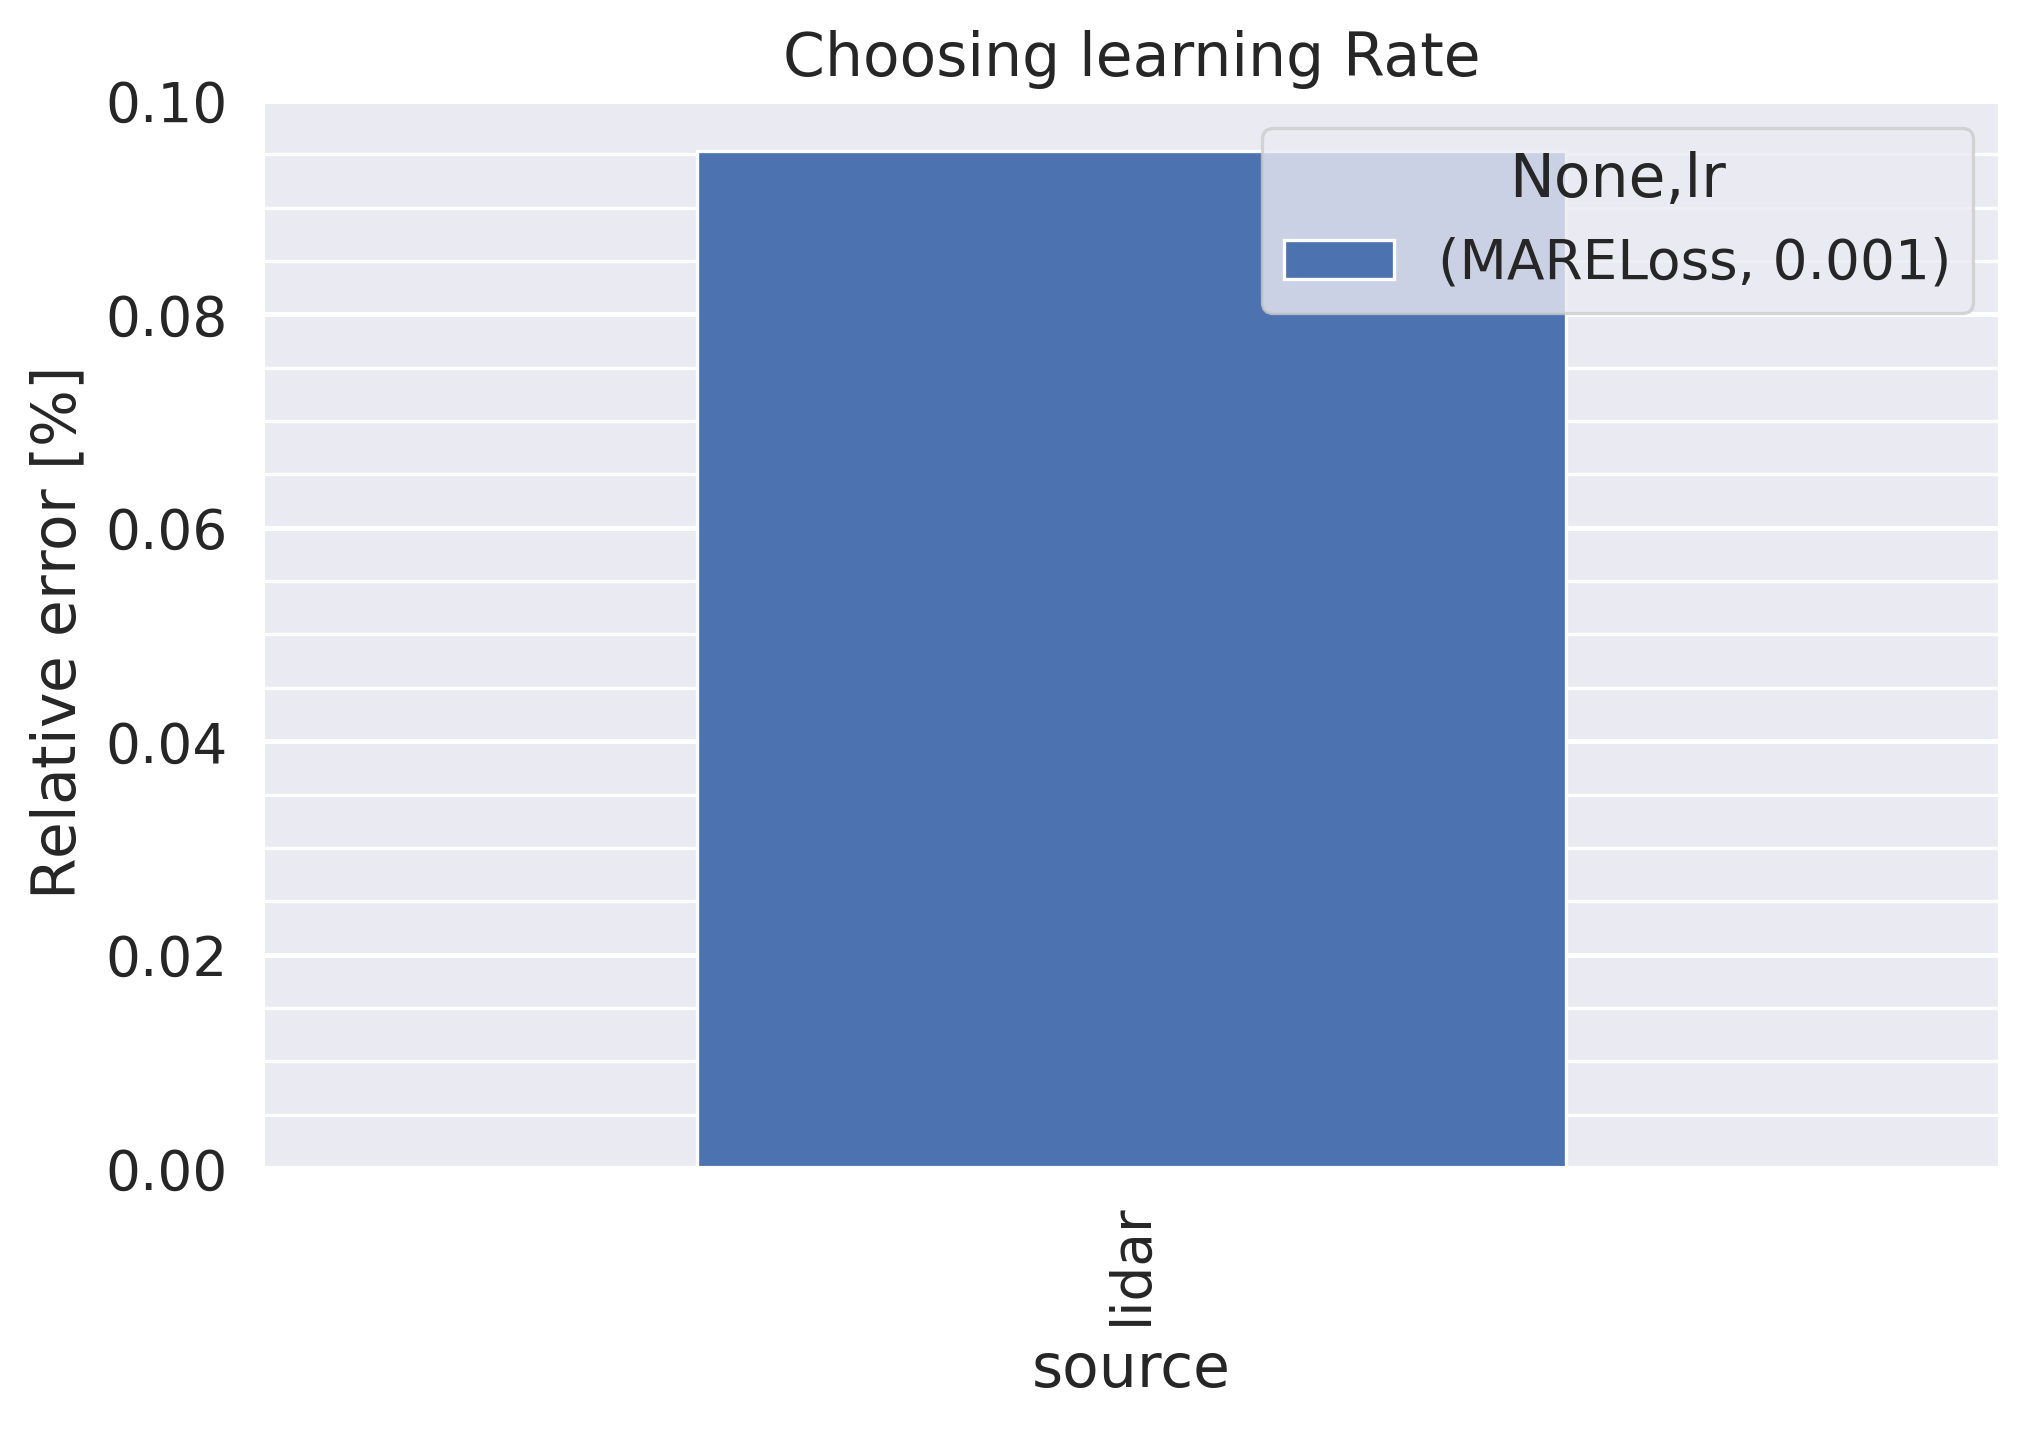

In [53]:
lidar_res = analyse_results[analyse_results.source=='lidar' ]
lidar_res = lidar_res[lidar_res.use_bg==False]
pow_lidar = lidar_res[(~lidar_res.dnorm & lidar_res.use_power ) ]

p_table = pd.pivot_table(pow_lidar[pow_lidar.bsize==32][pow_lidar.fc_size>4],#[pow_lidar.note=='ok'],
               values=['MARELoss'],
               columns= ['lr'],
               index=['source'],#'fc_size'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Choosing learning Rate')

## 2. FC vs. hidden sizes
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar
> lr = 0.001 or lr = 0.005

In [54]:
all_wav = analyse_results #[analyse_results.wavelength=='all']
all_wavs_configABCD = all_wav[all_wav.config!='Other']

<ipython-input-55-0282a16facb1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
<ipython-input-55-0282a16facb1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]


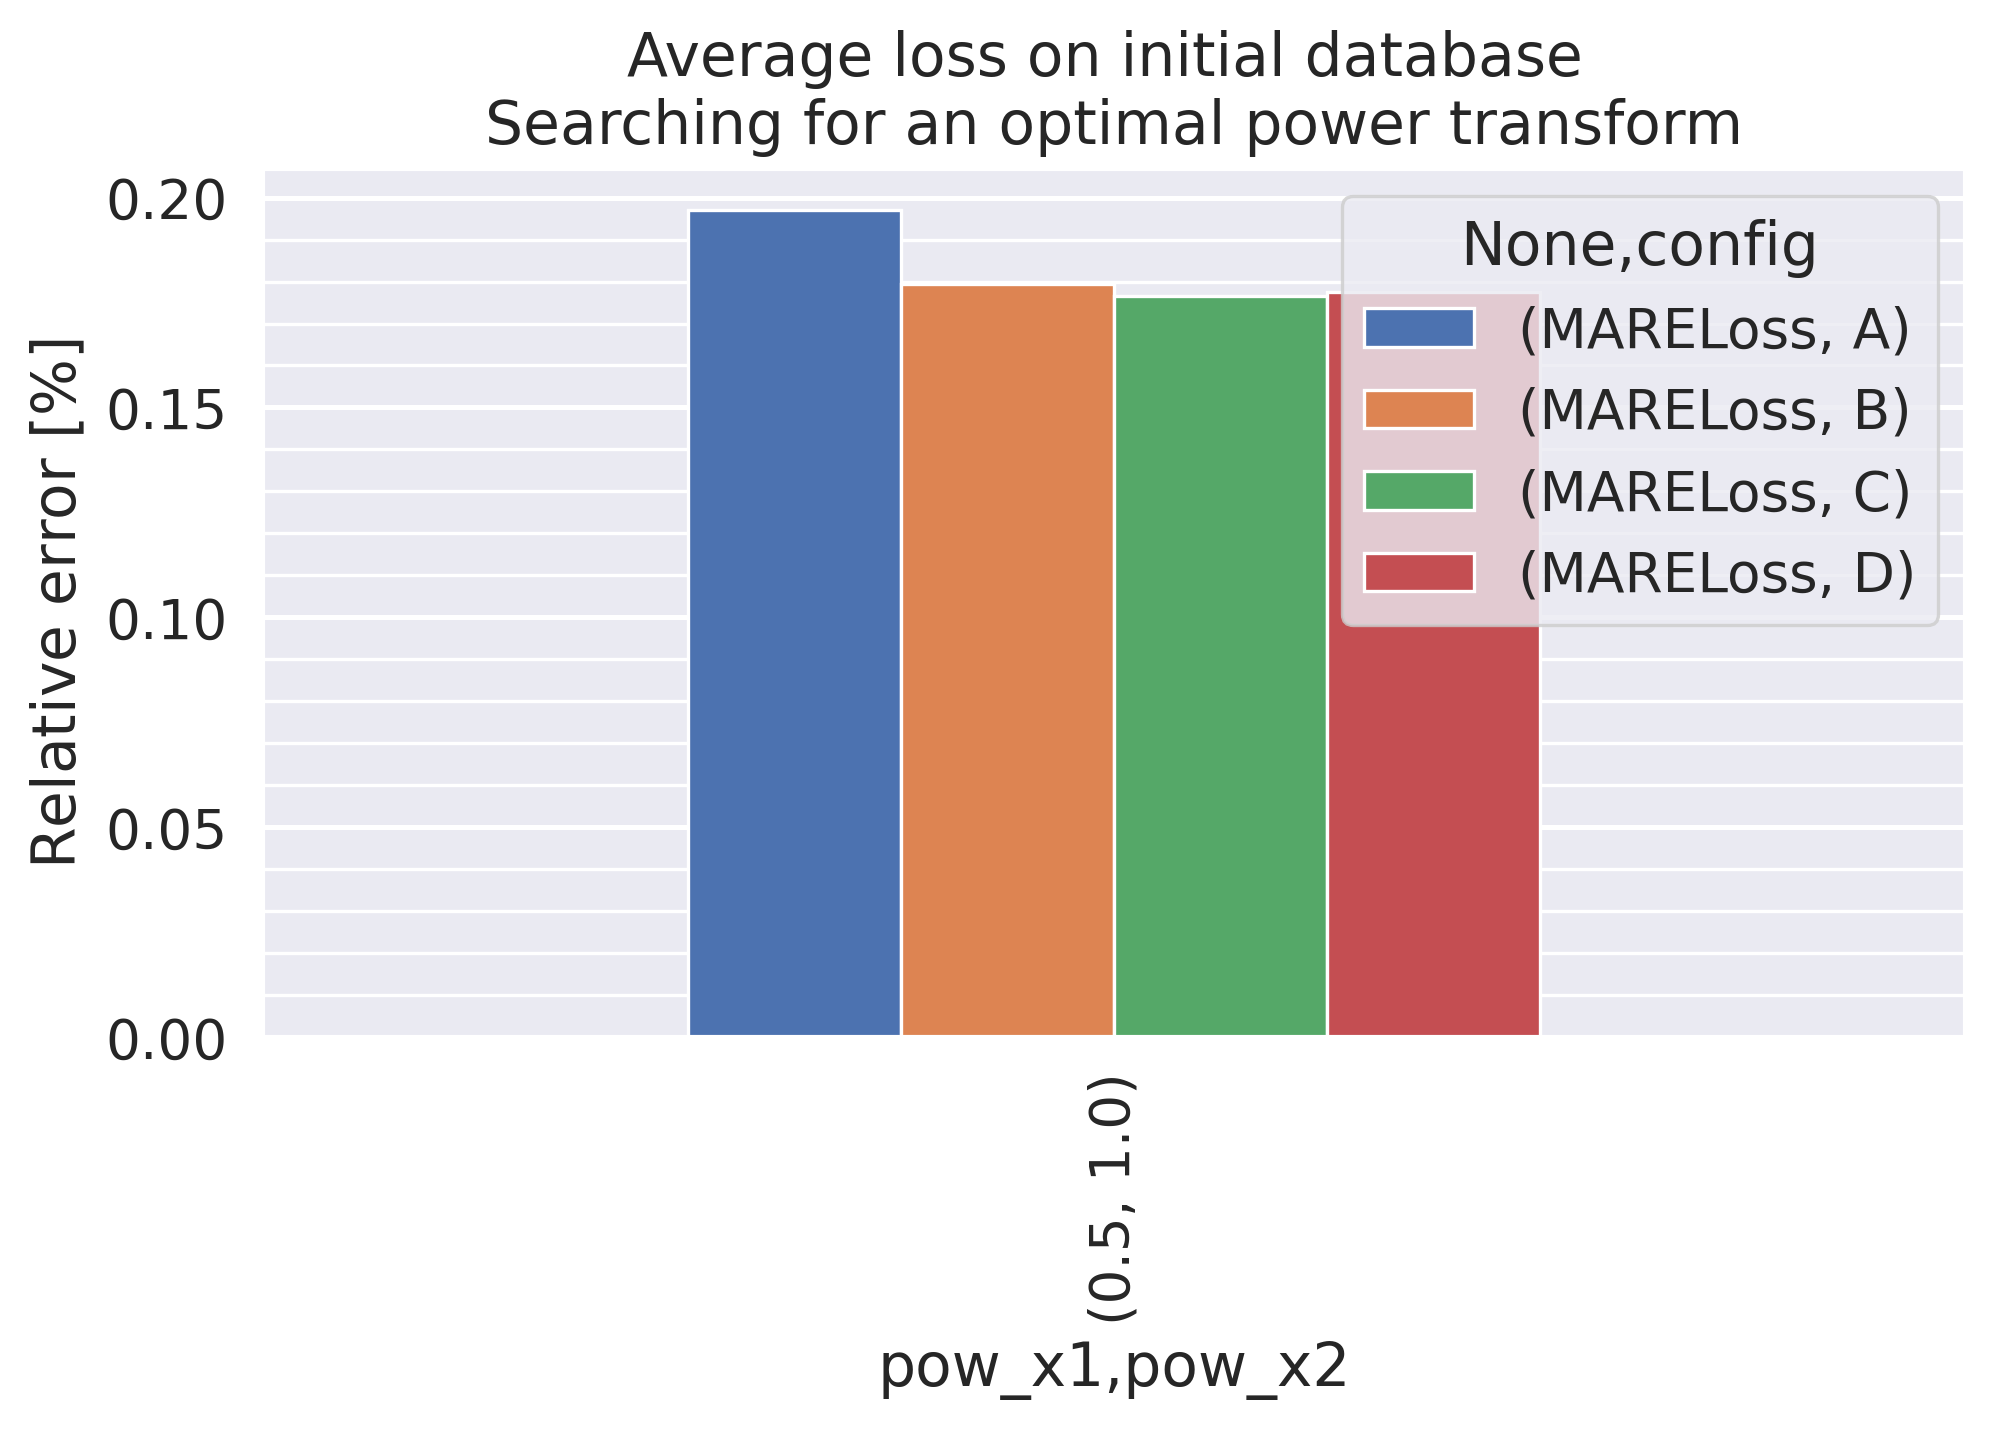

In [55]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
               [all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.use_power!=False]
               [all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['pow_x1','pow_x2'],
               aggfunc=np.mean)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Average loss on initial database \n Searching for an optimal power transform ')

<ipython-input-56-815bc3f2b368>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]


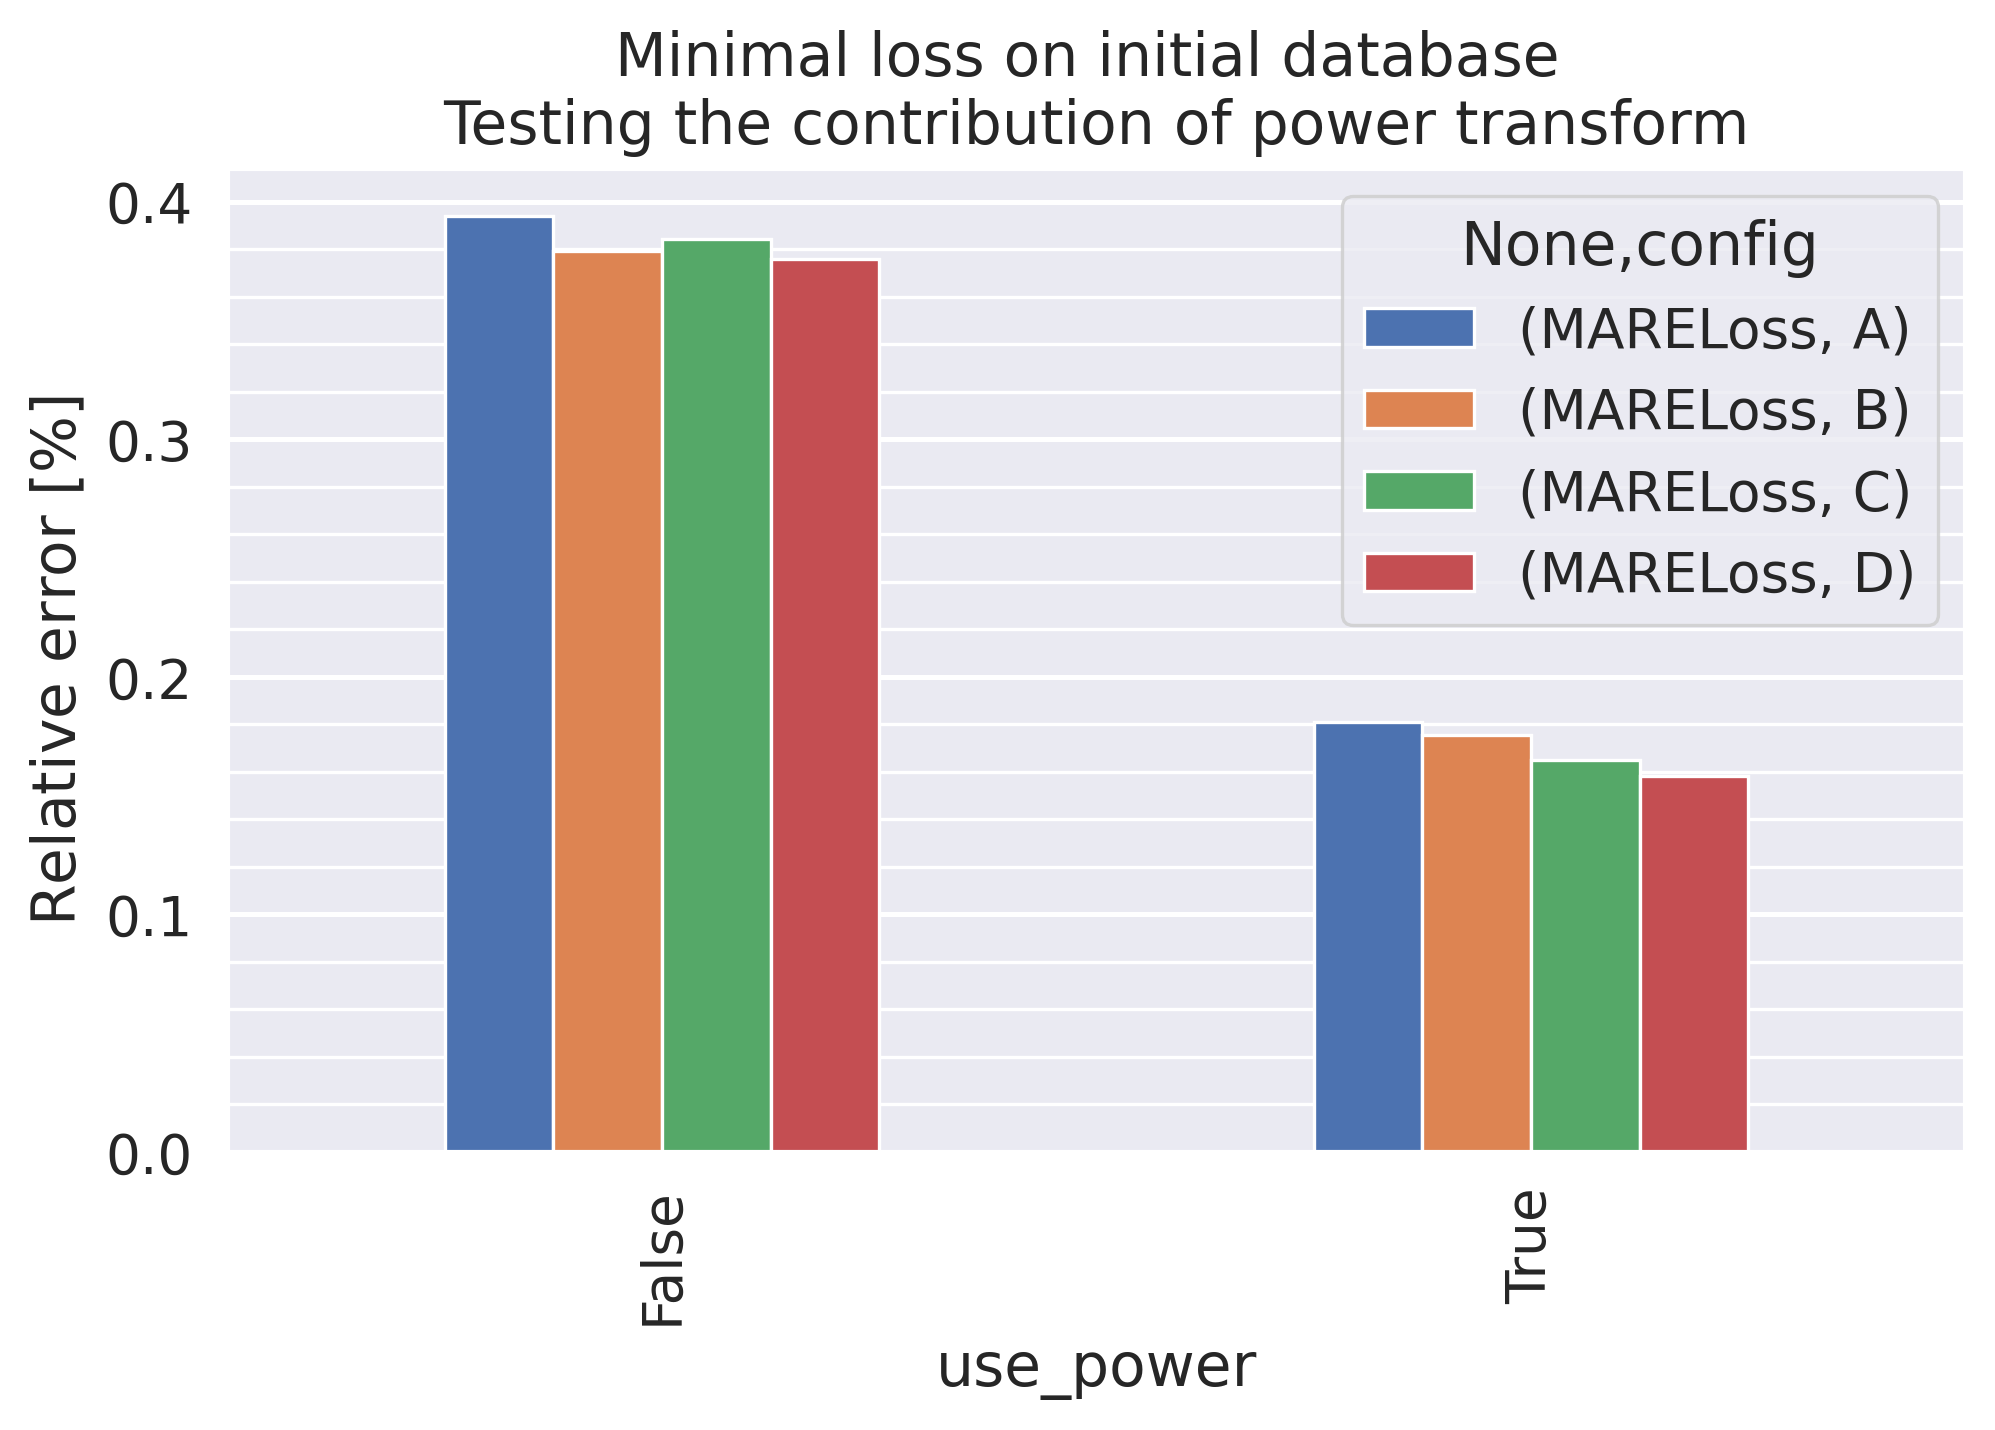

In [56]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
                         [all_wavs_configABCD.use_bg!='range_corr']
                         [all_wavs_configABCD.note=='initial_db']
                         [all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Minimal loss on initial database \n Testing the contribution of power transform ')

<ipython-input-57-5aa6d3b017df>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],


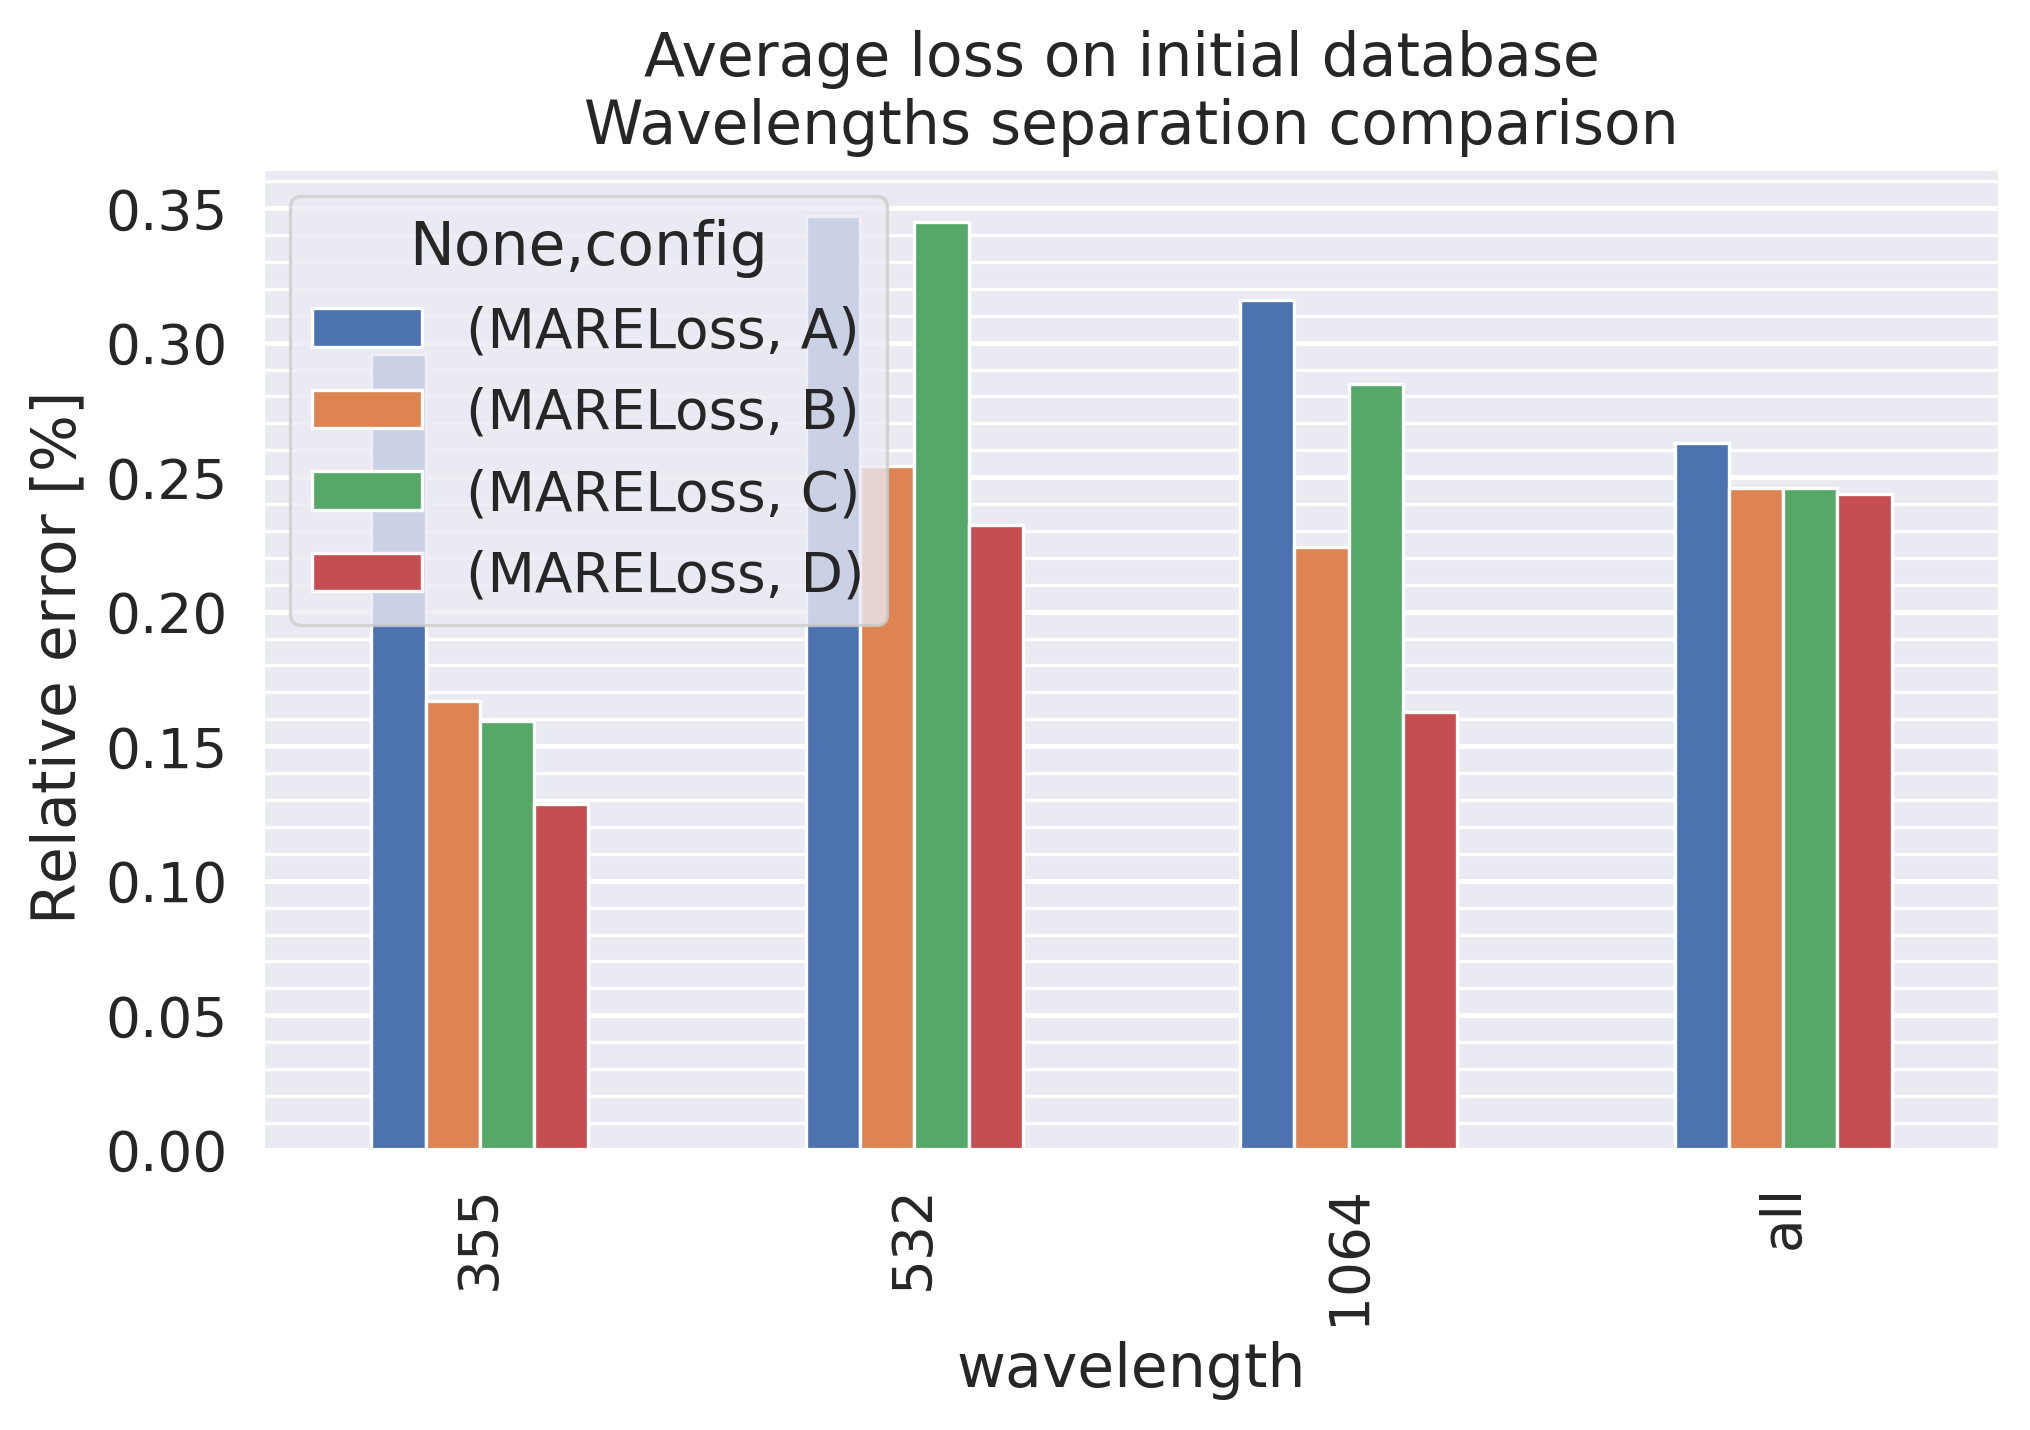

In [57]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.mean)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Average loss on initial database \n Wavelengths separation comparison ')

<ipython-input-58-cbcfadeb0093>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


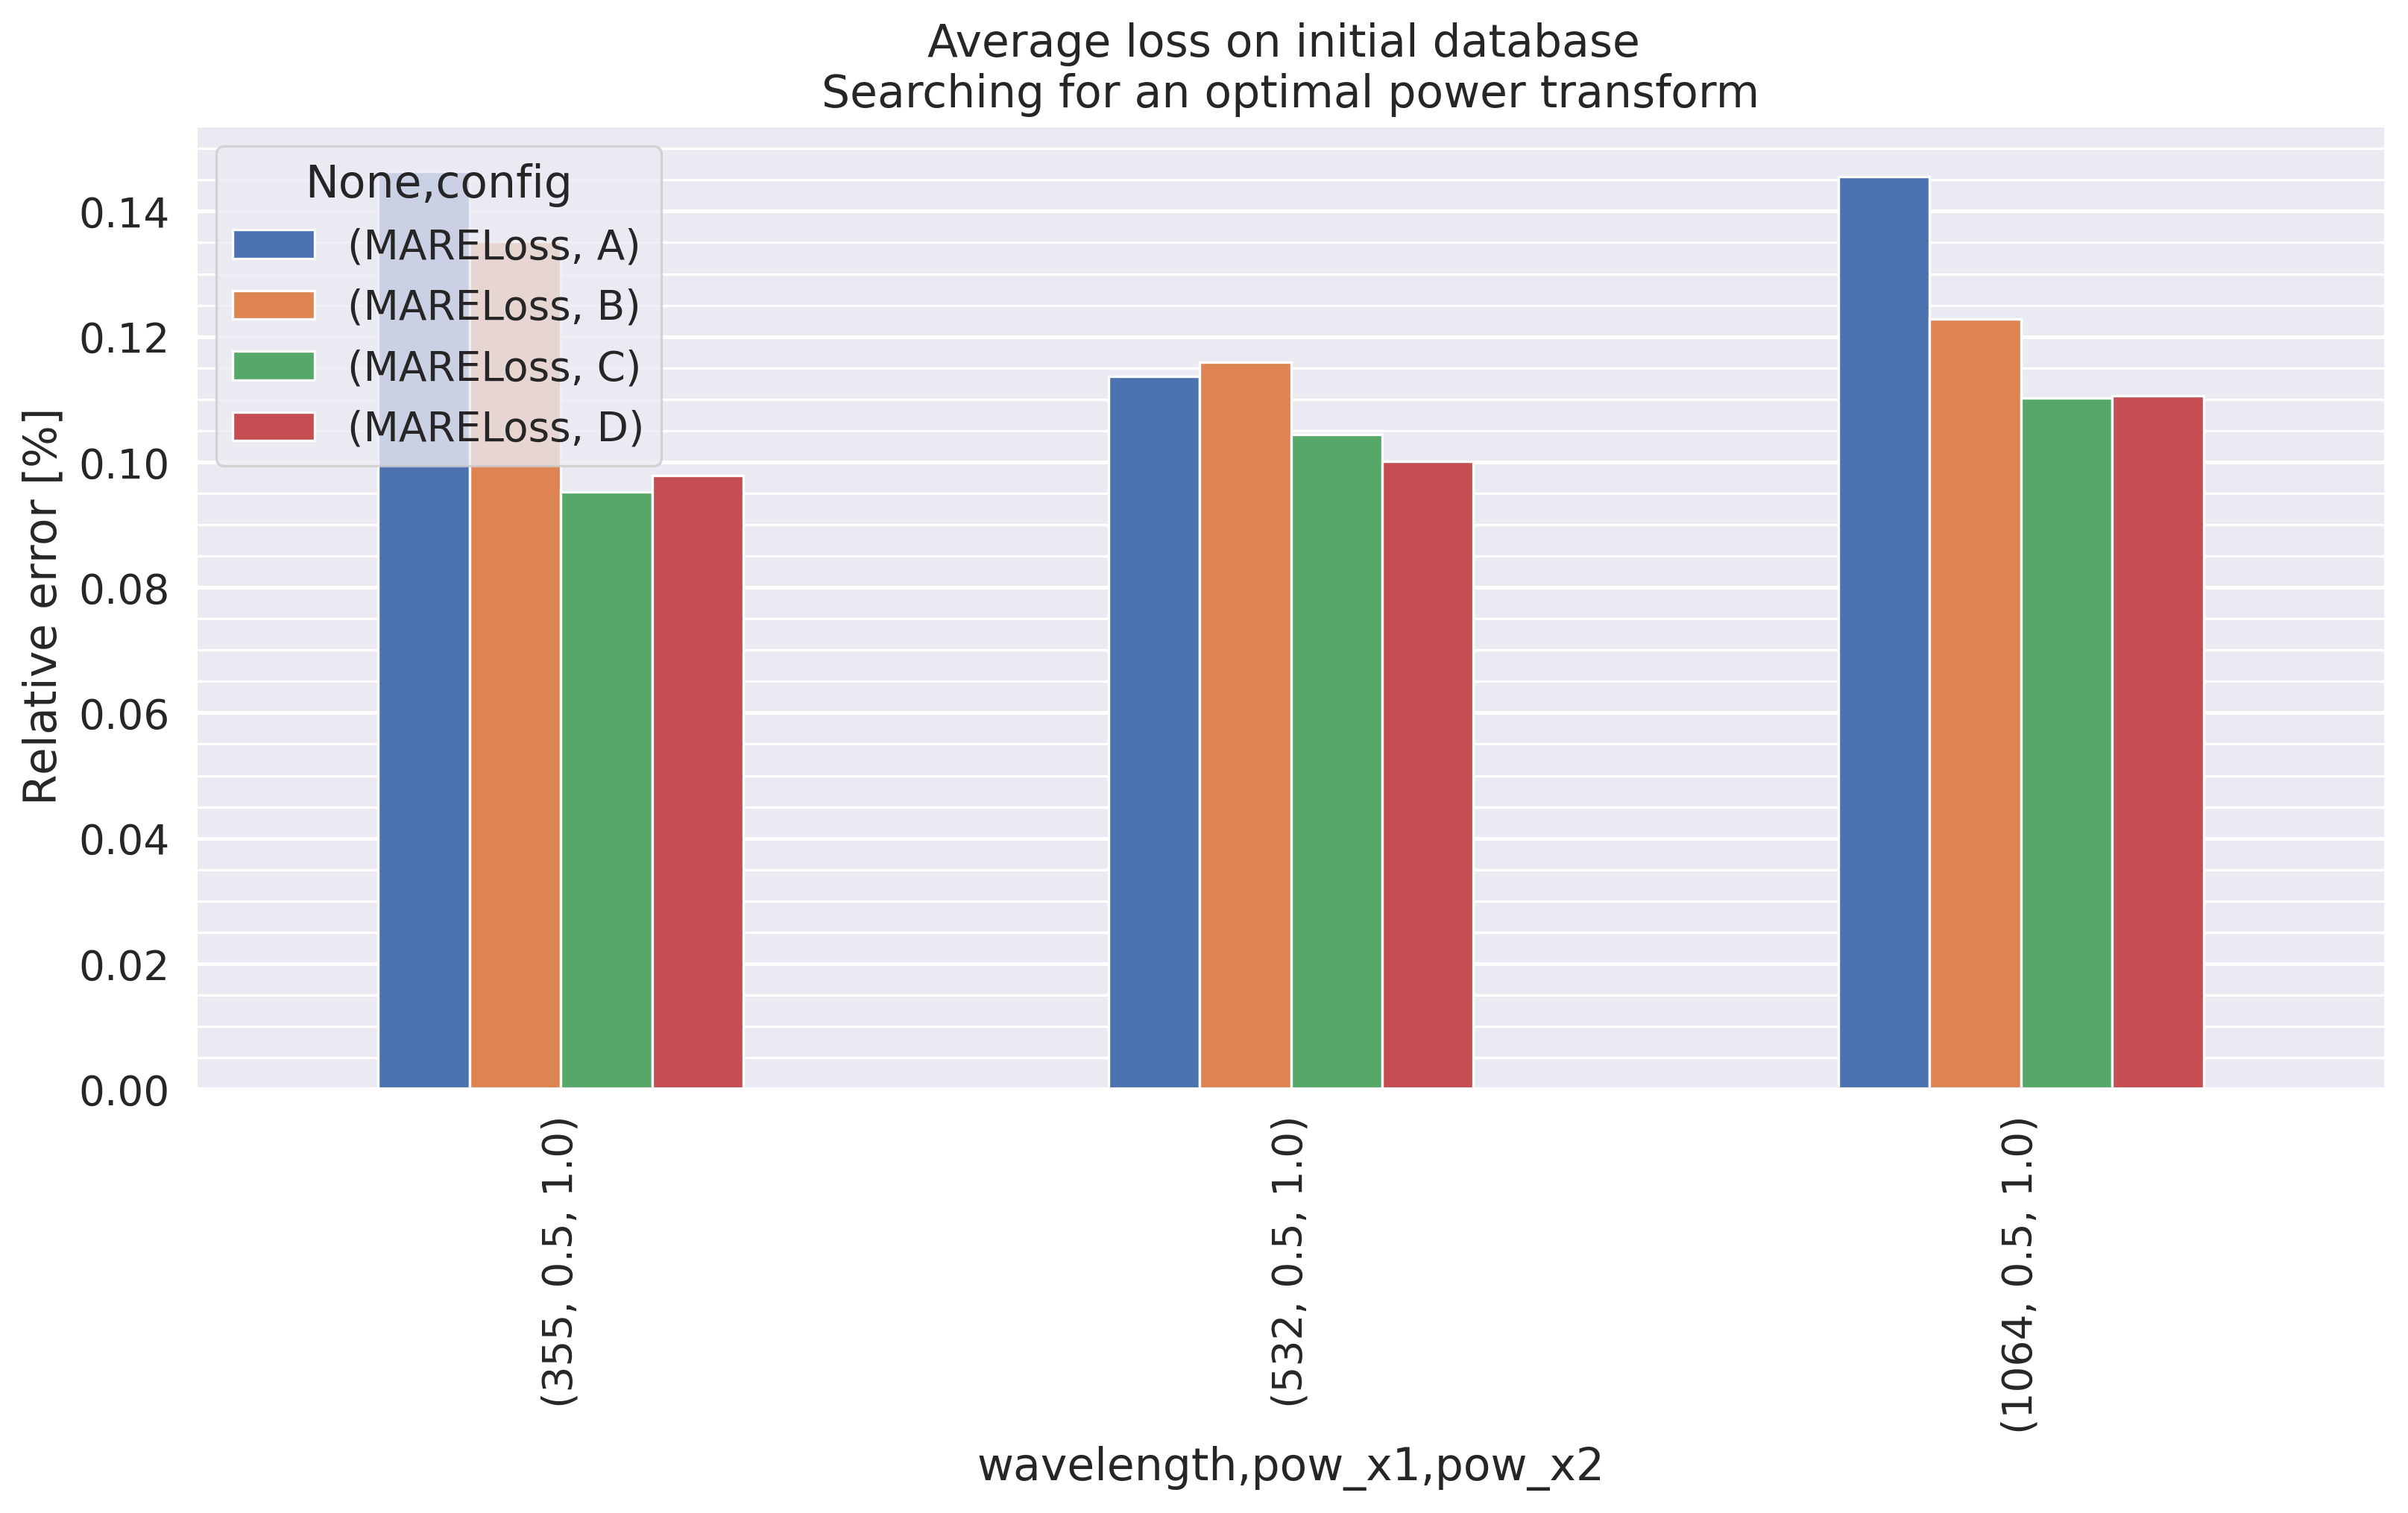

In [58]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7),
                 title='Average loss on initial database \n Searching for an optimal power transform ')

<ipython-input-59-39b0ec046bf7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


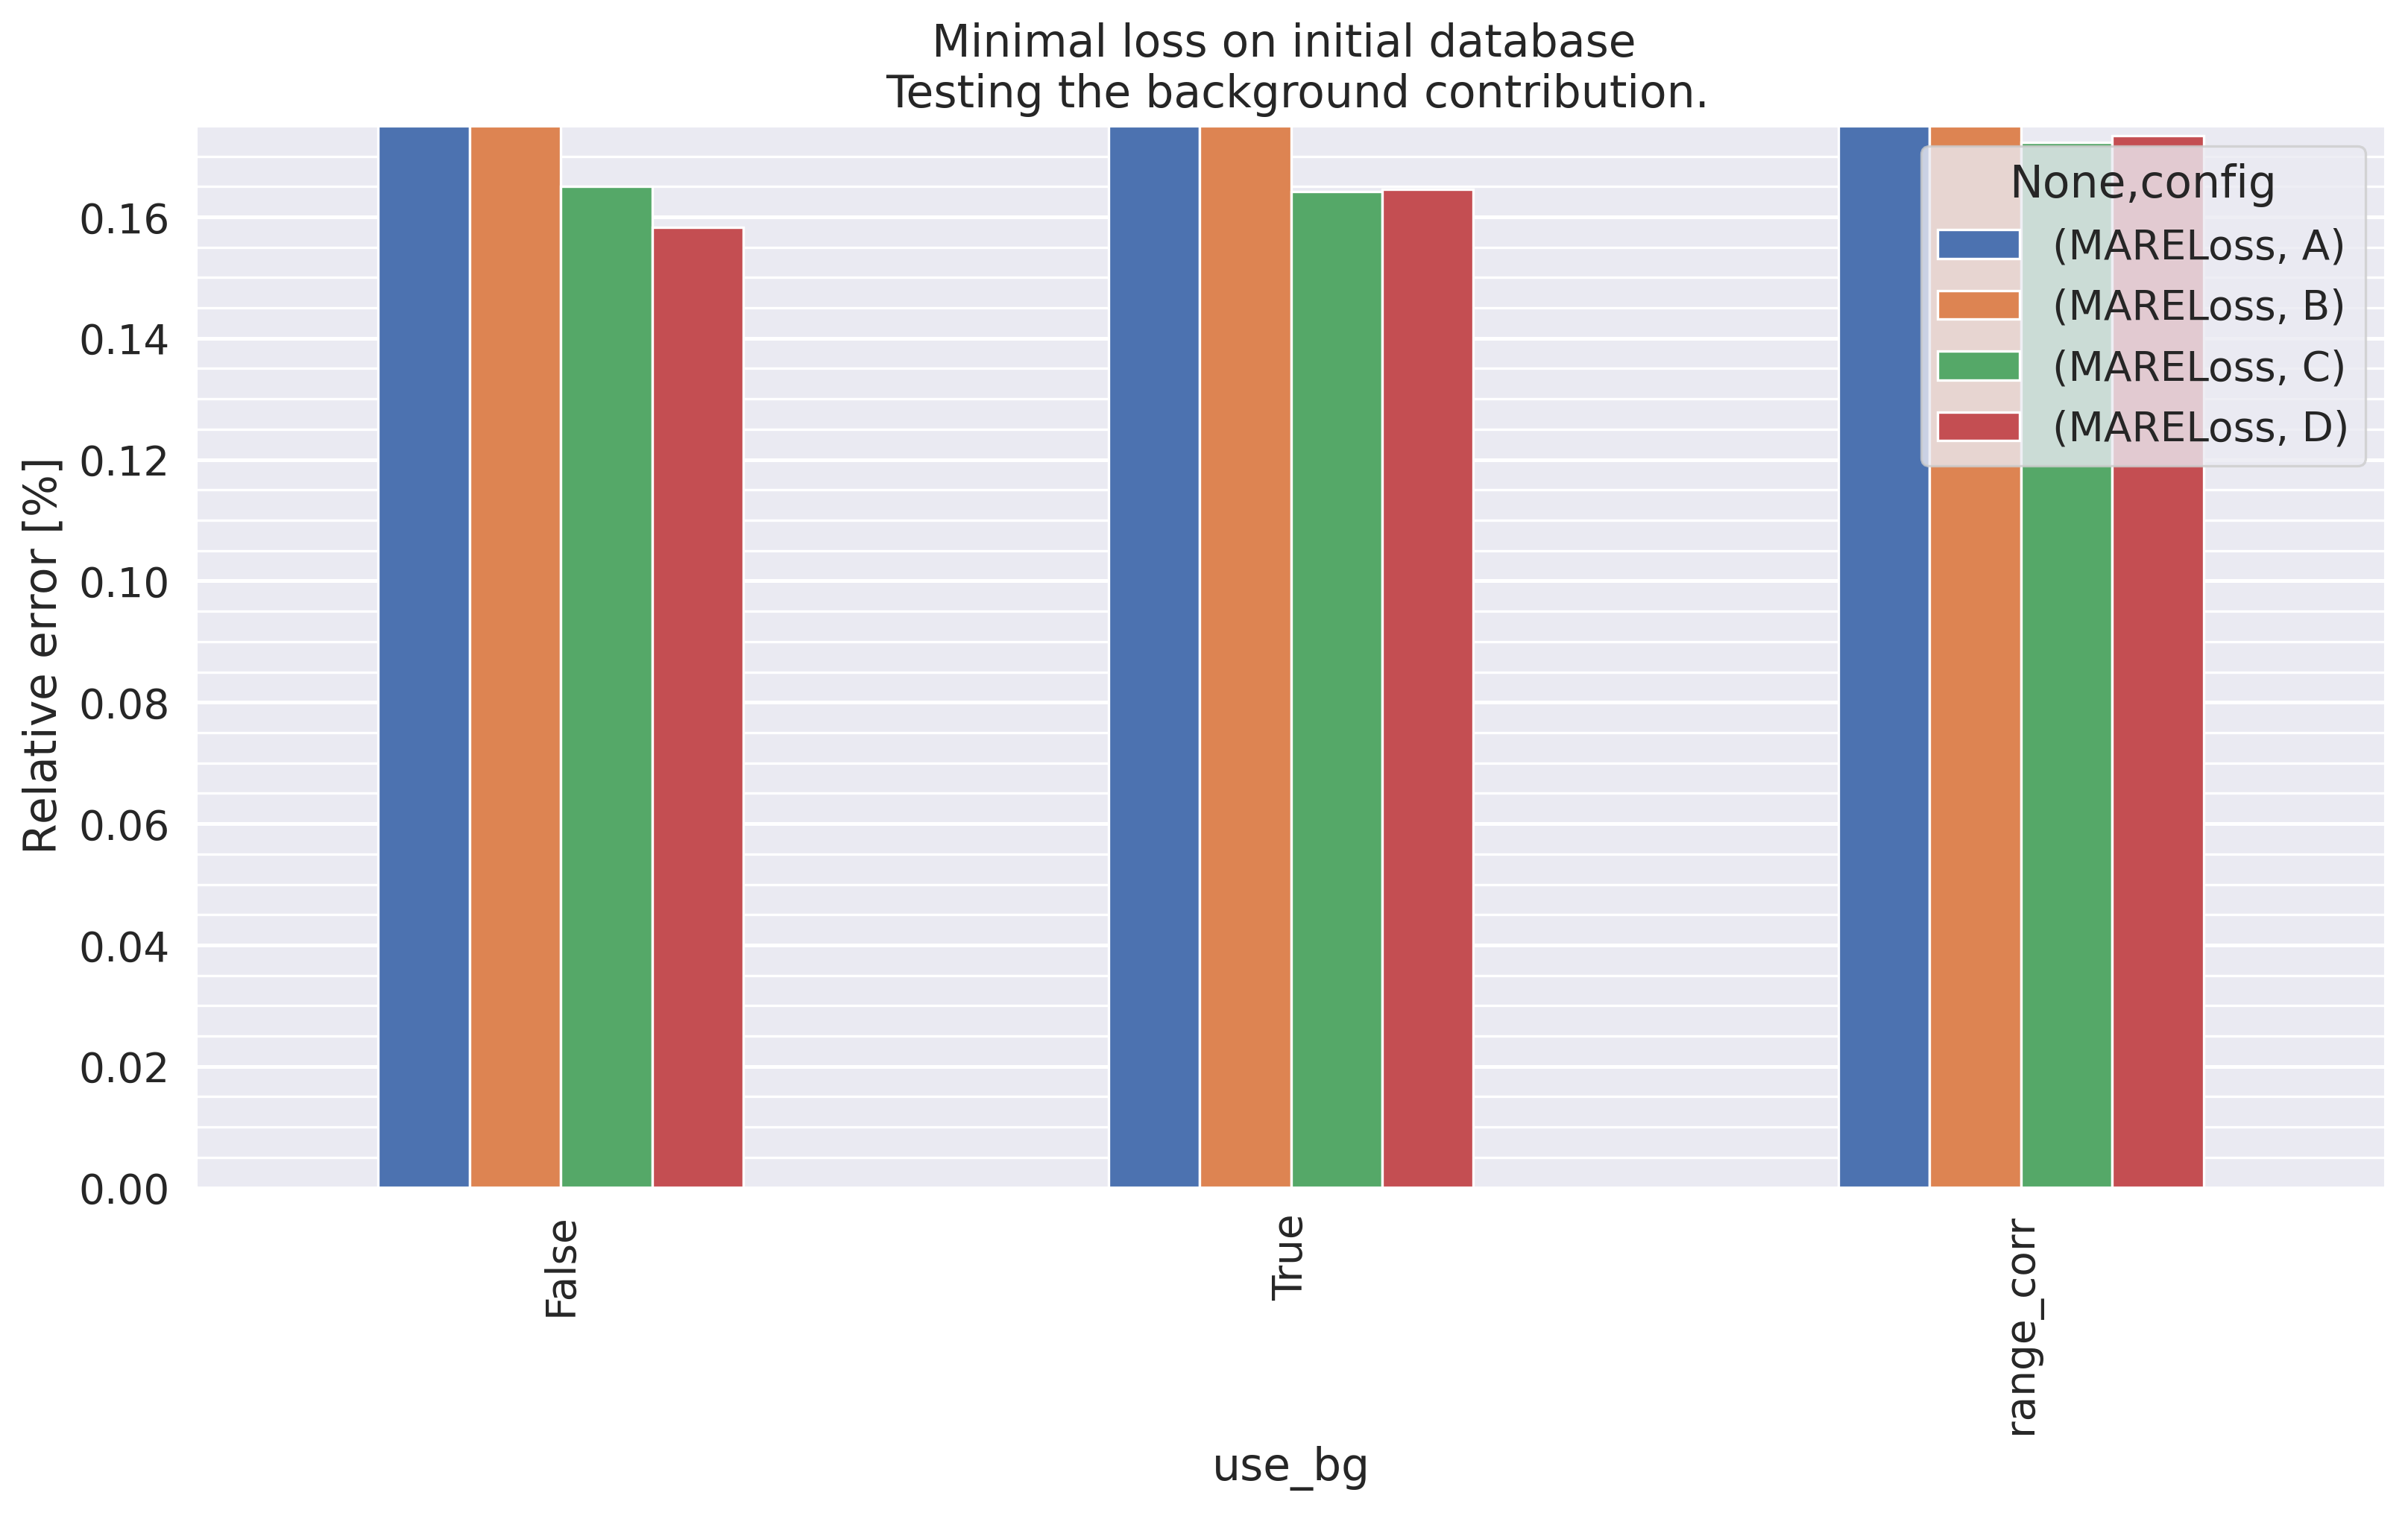

In [59]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
               [all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7), ylim= [0.0, 0.175],
                 title='Minimal loss on initial database \n Testing the background contribution.')

<ipython-input-60-e9fe8bb4334b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


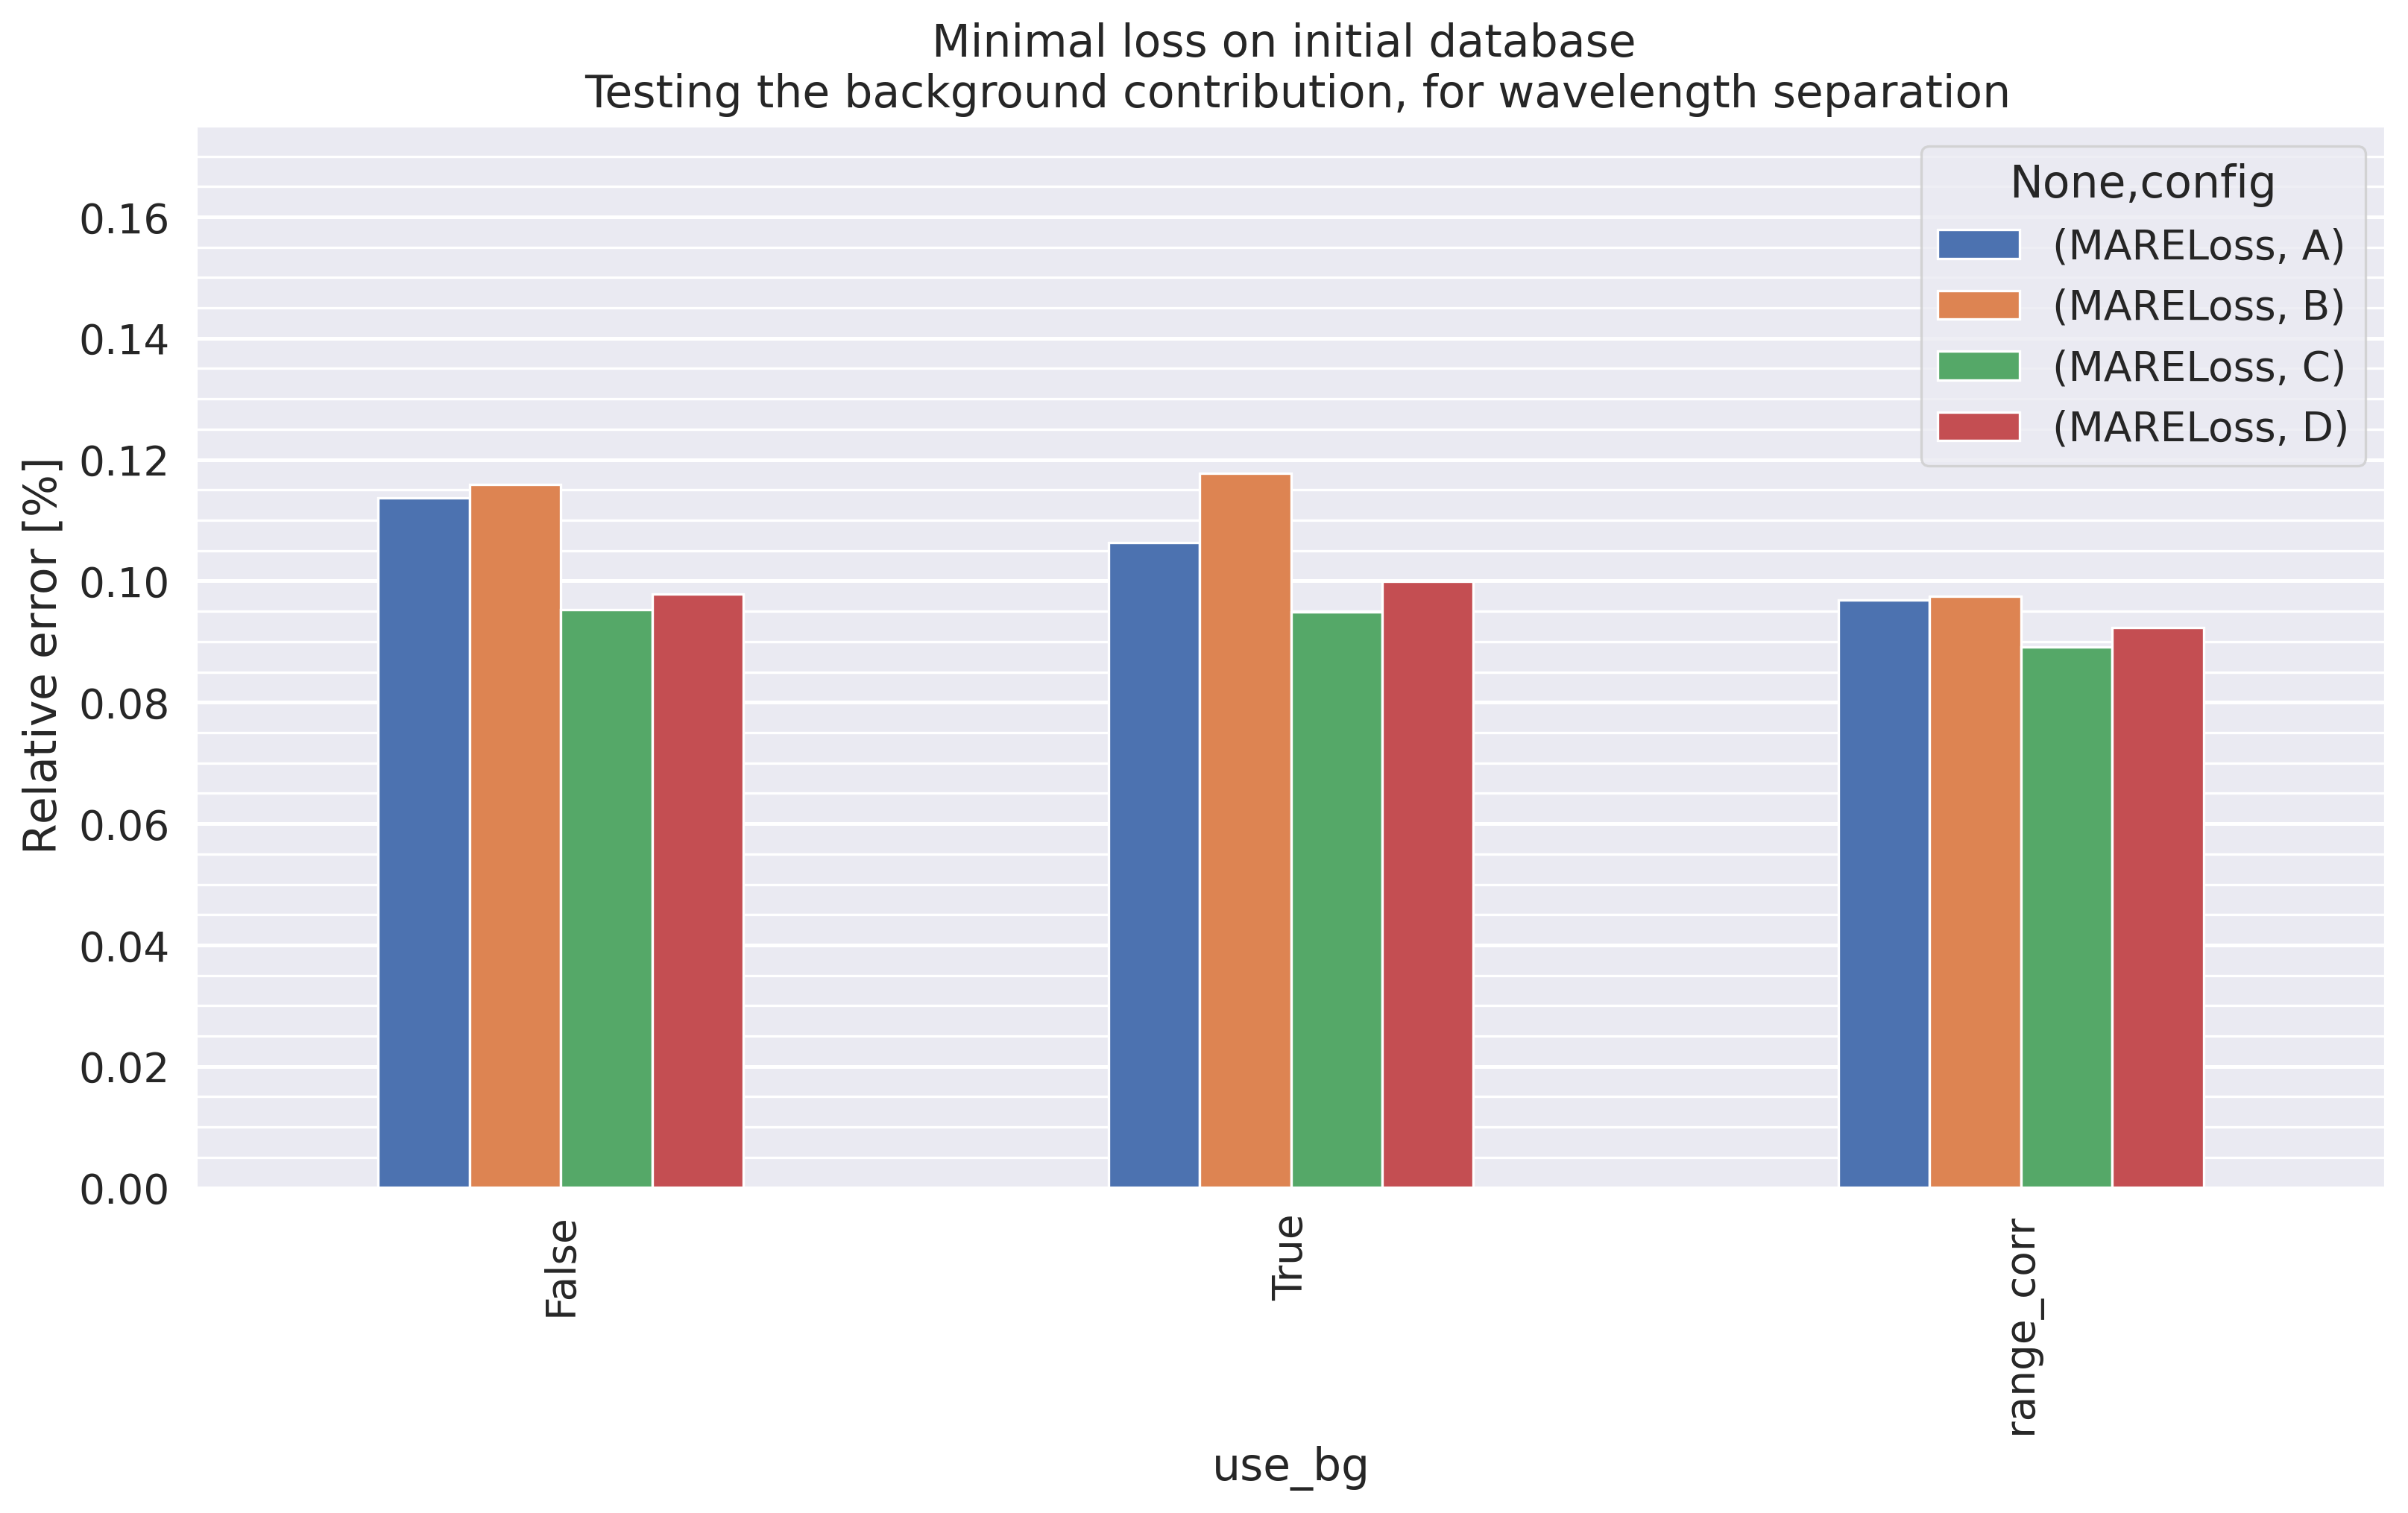

In [60]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7), ylim= [0.0, 0.175],
                 title='Minimal loss on initial database \n Testing the background contribution, for wavelength separation')

<ipython-input-61-ab738cf22a8f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


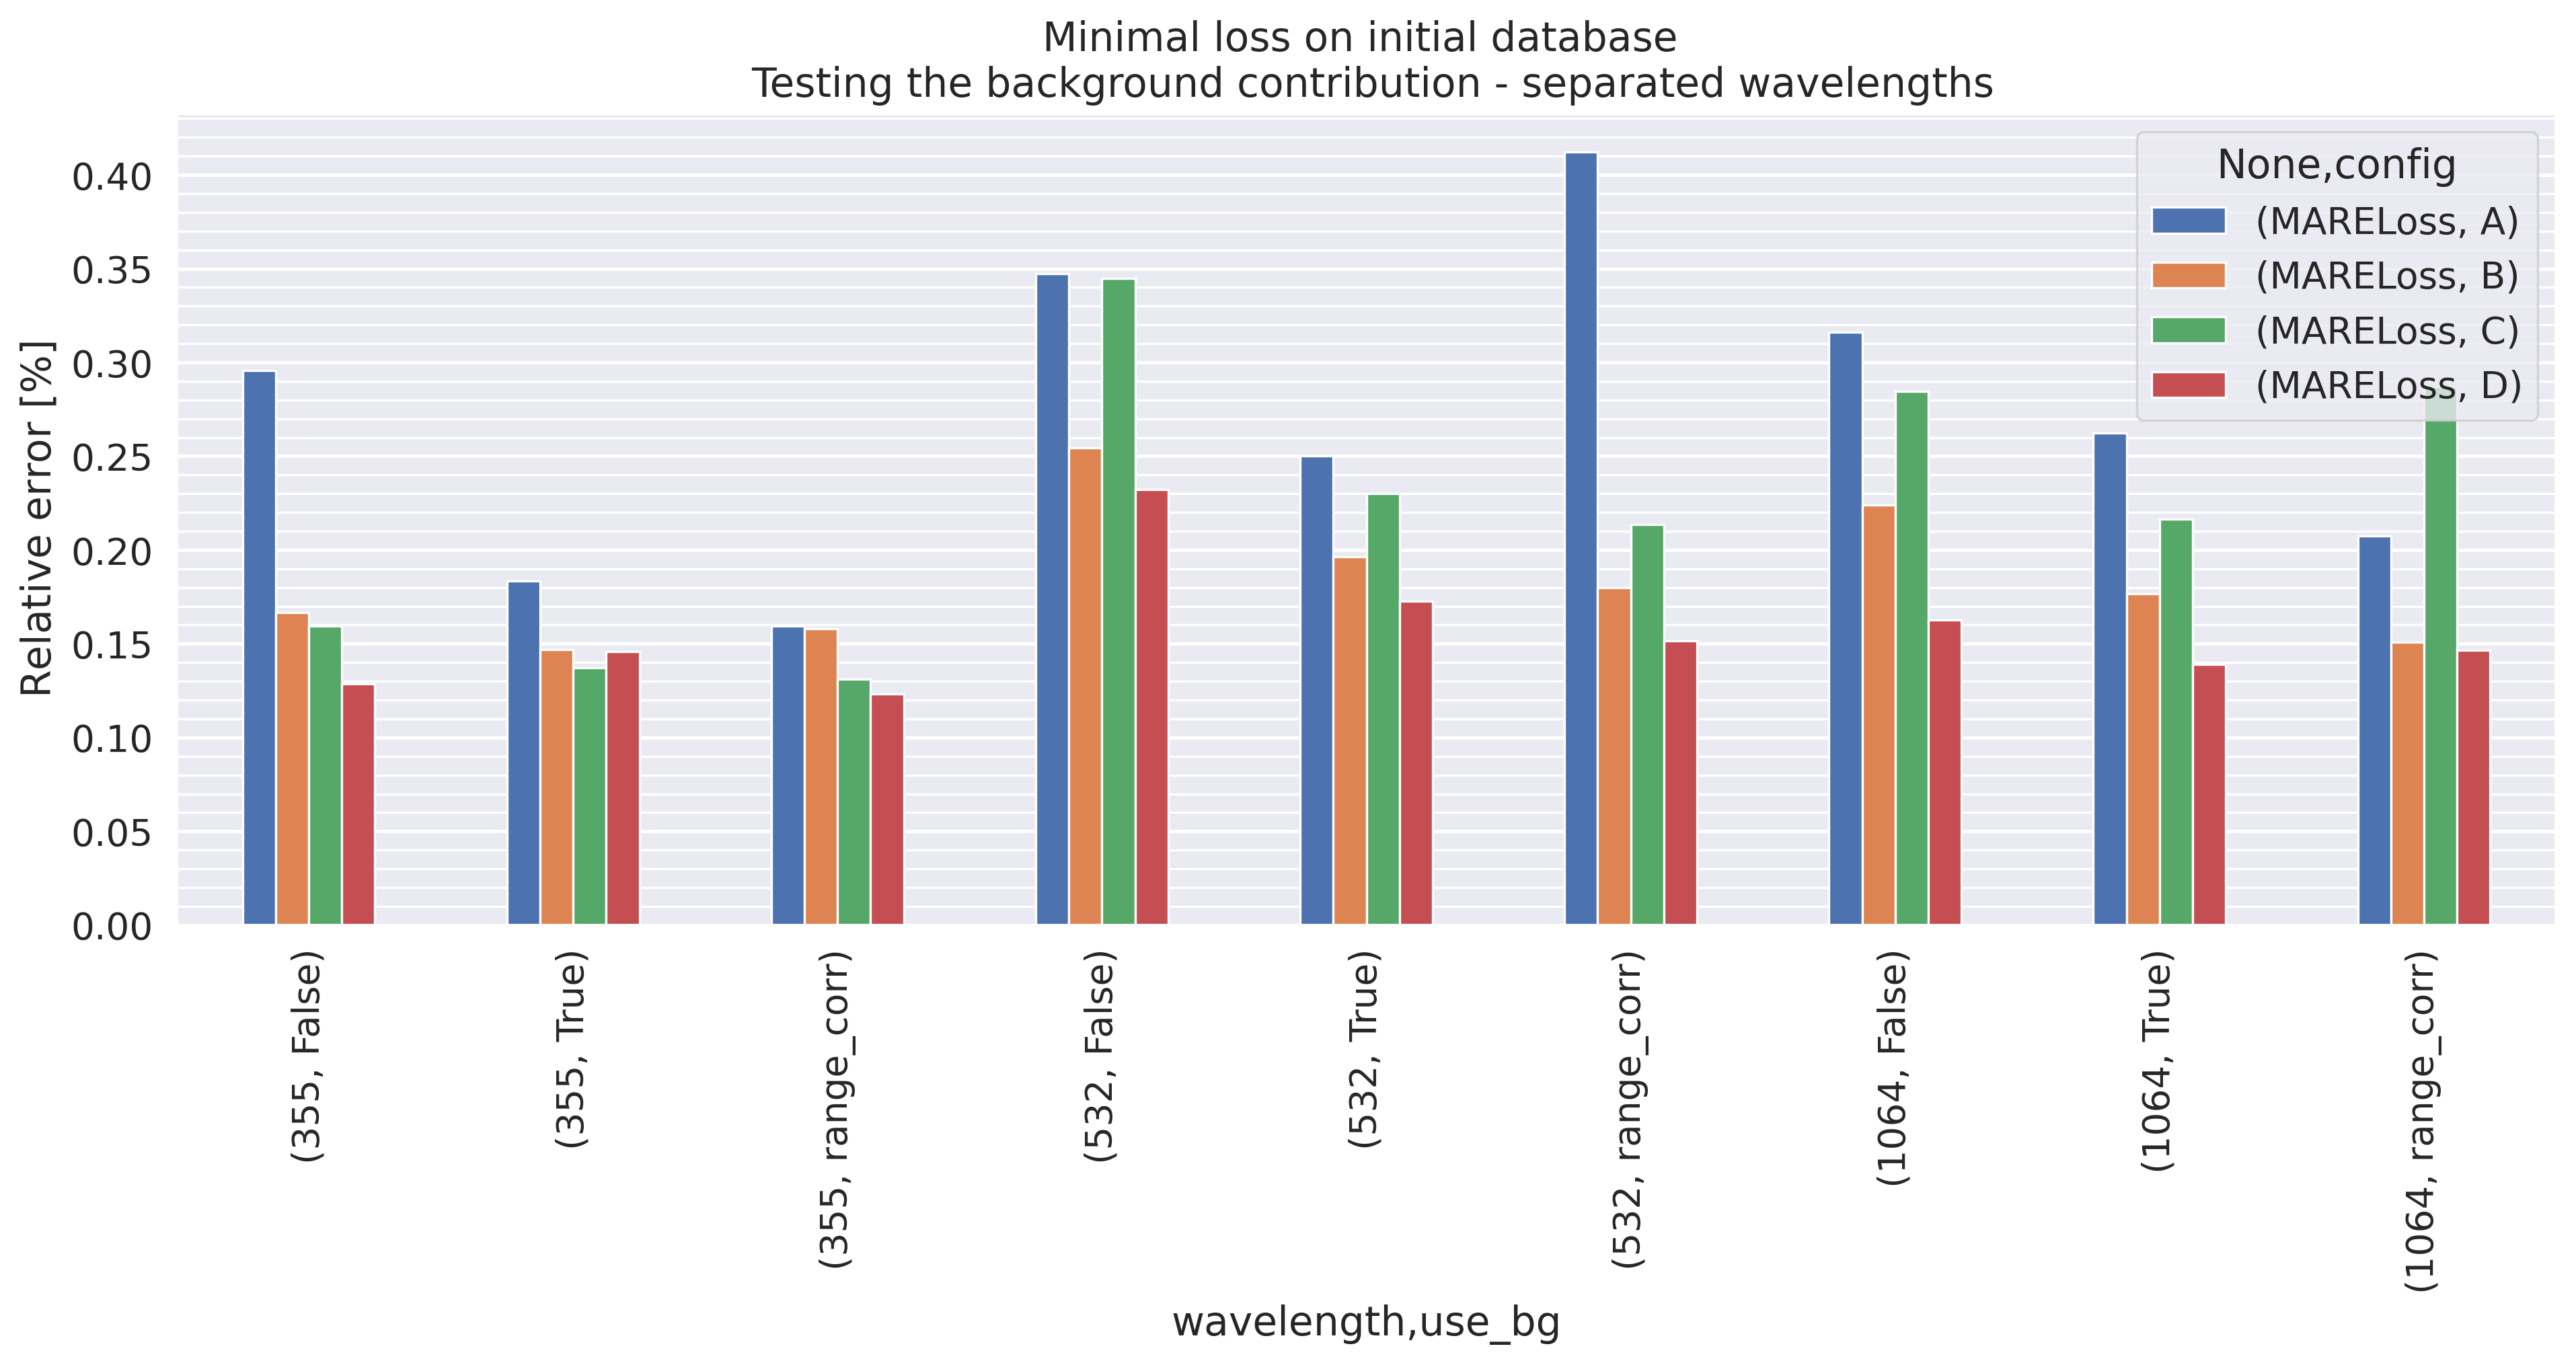

In [61]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_bg'],
               aggfunc=np.mean)

plot_pivot_table(p_table, figsize=(13, 7),
                 title='Minimal loss on initial database \n Testing the background contribution - separated wavelengths')

<ipython-input-62-290bd25e3827>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


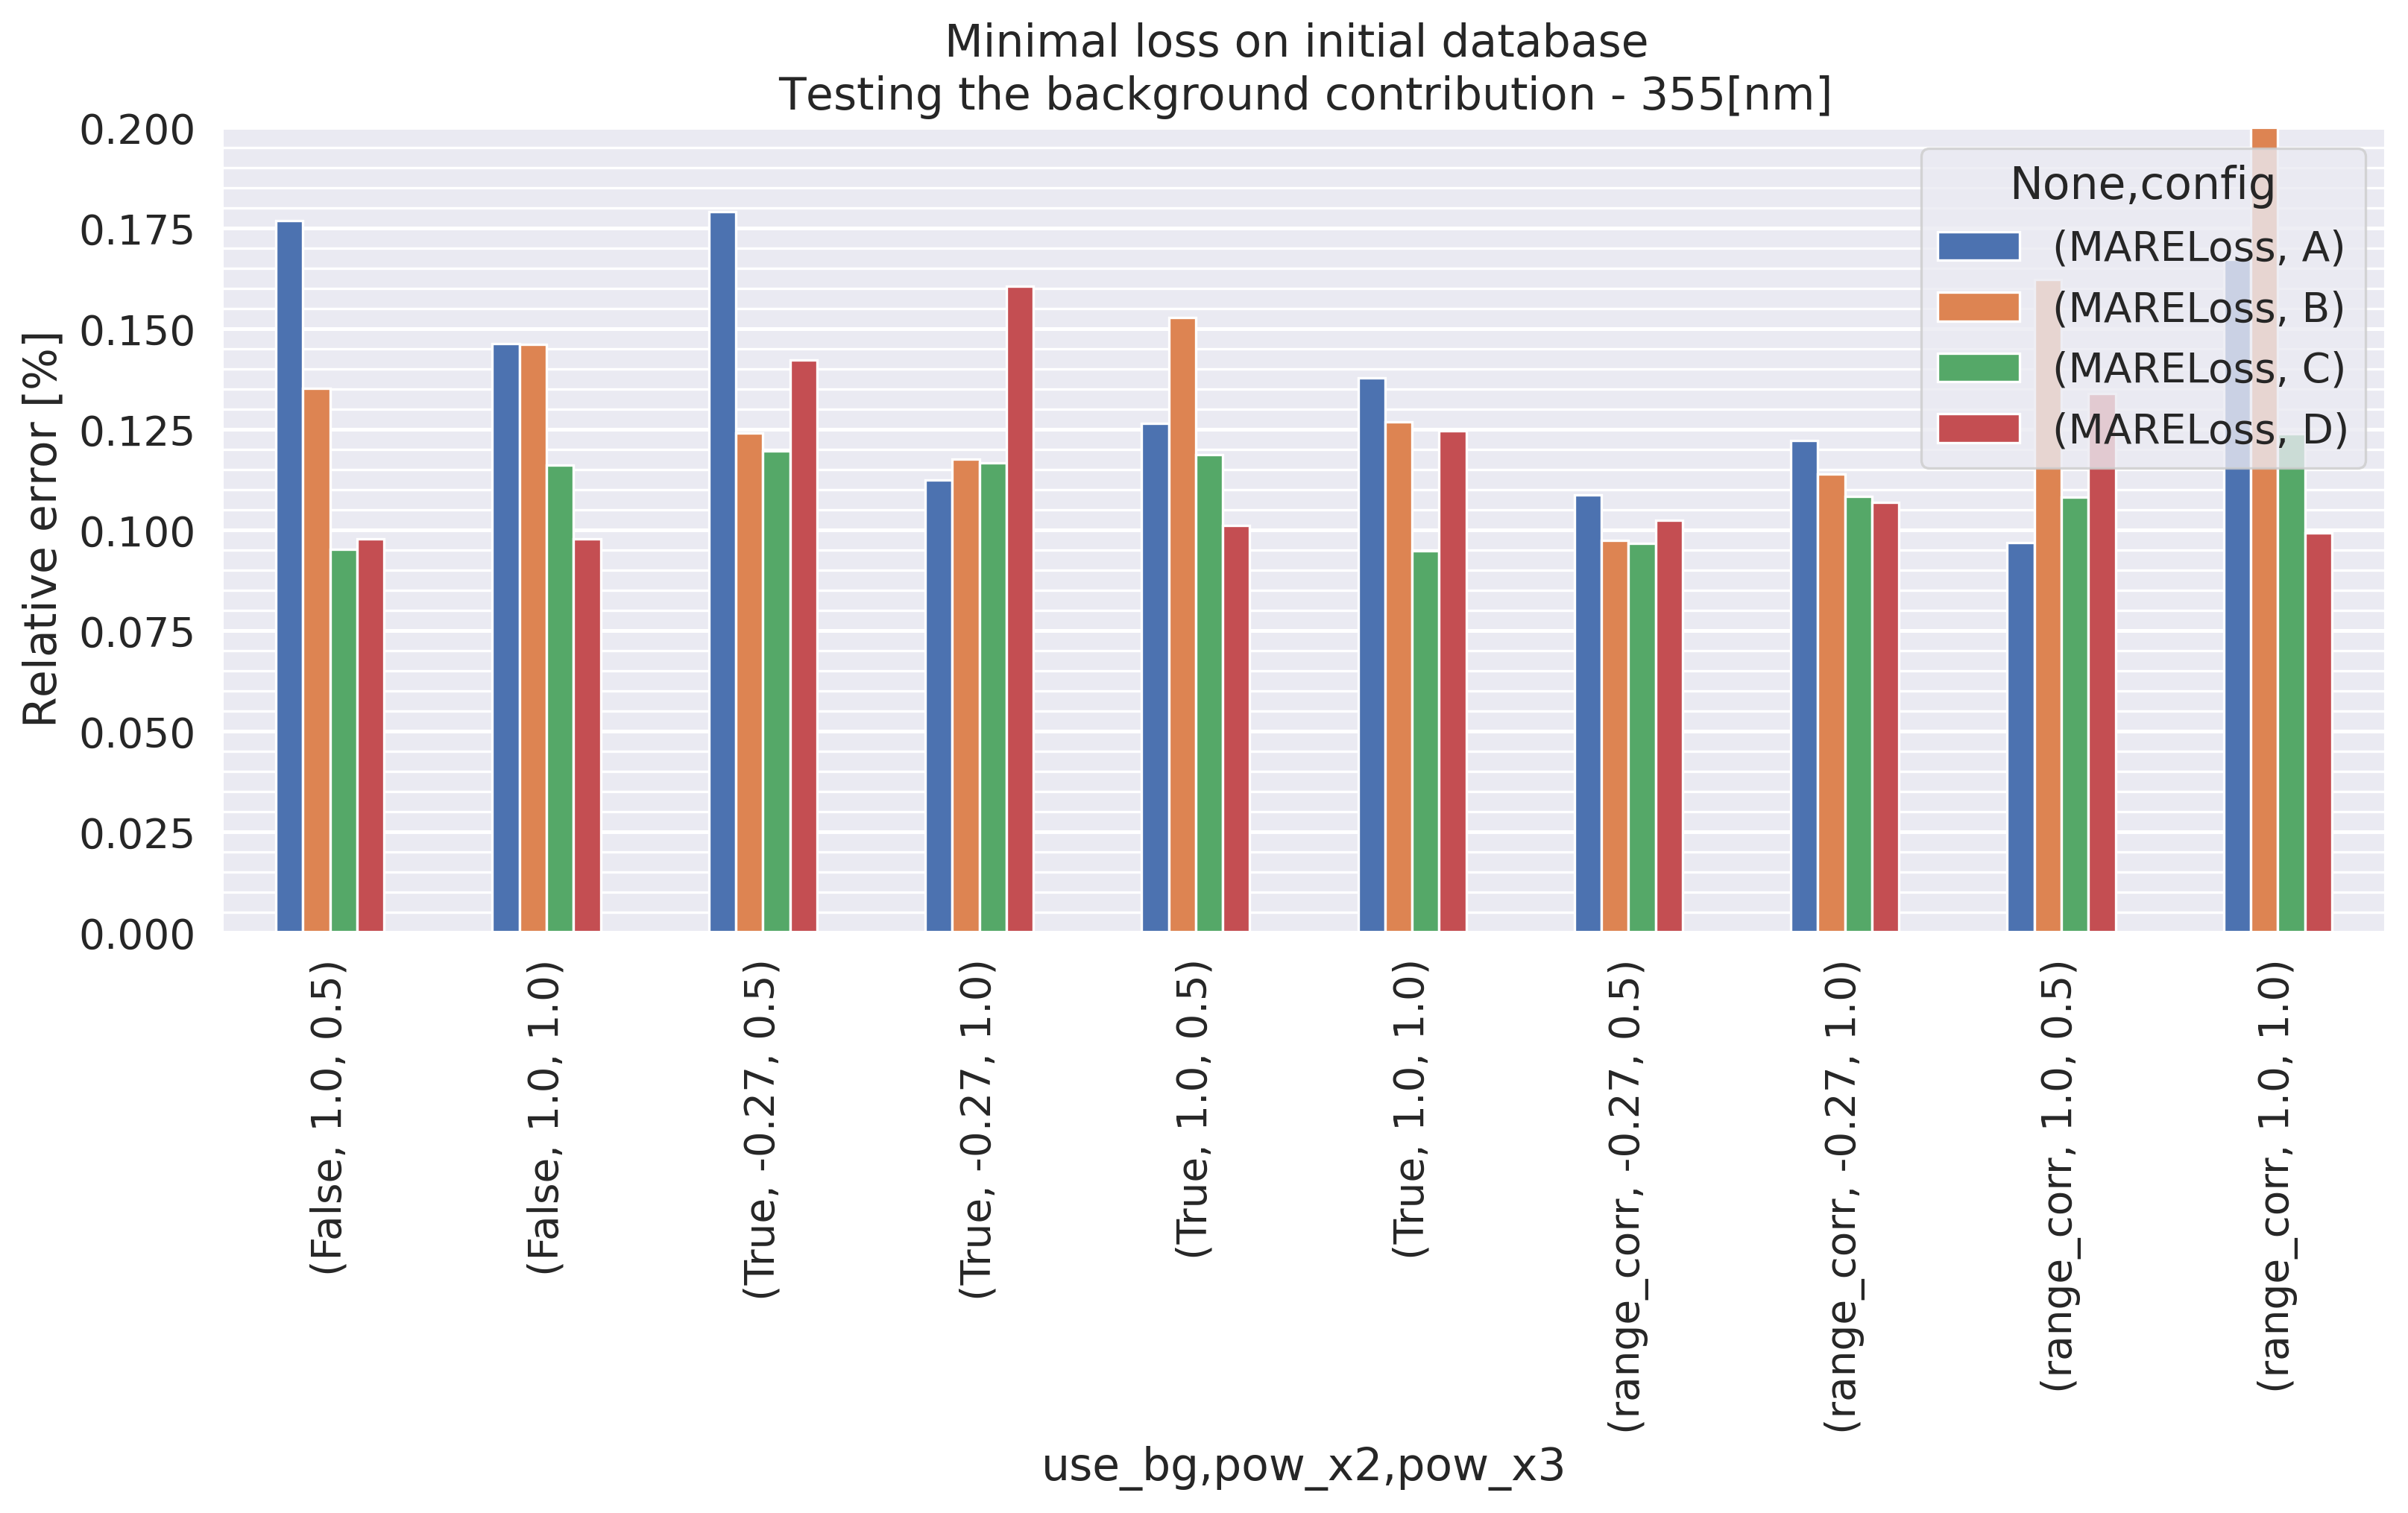

<ipython-input-62-290bd25e3827>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


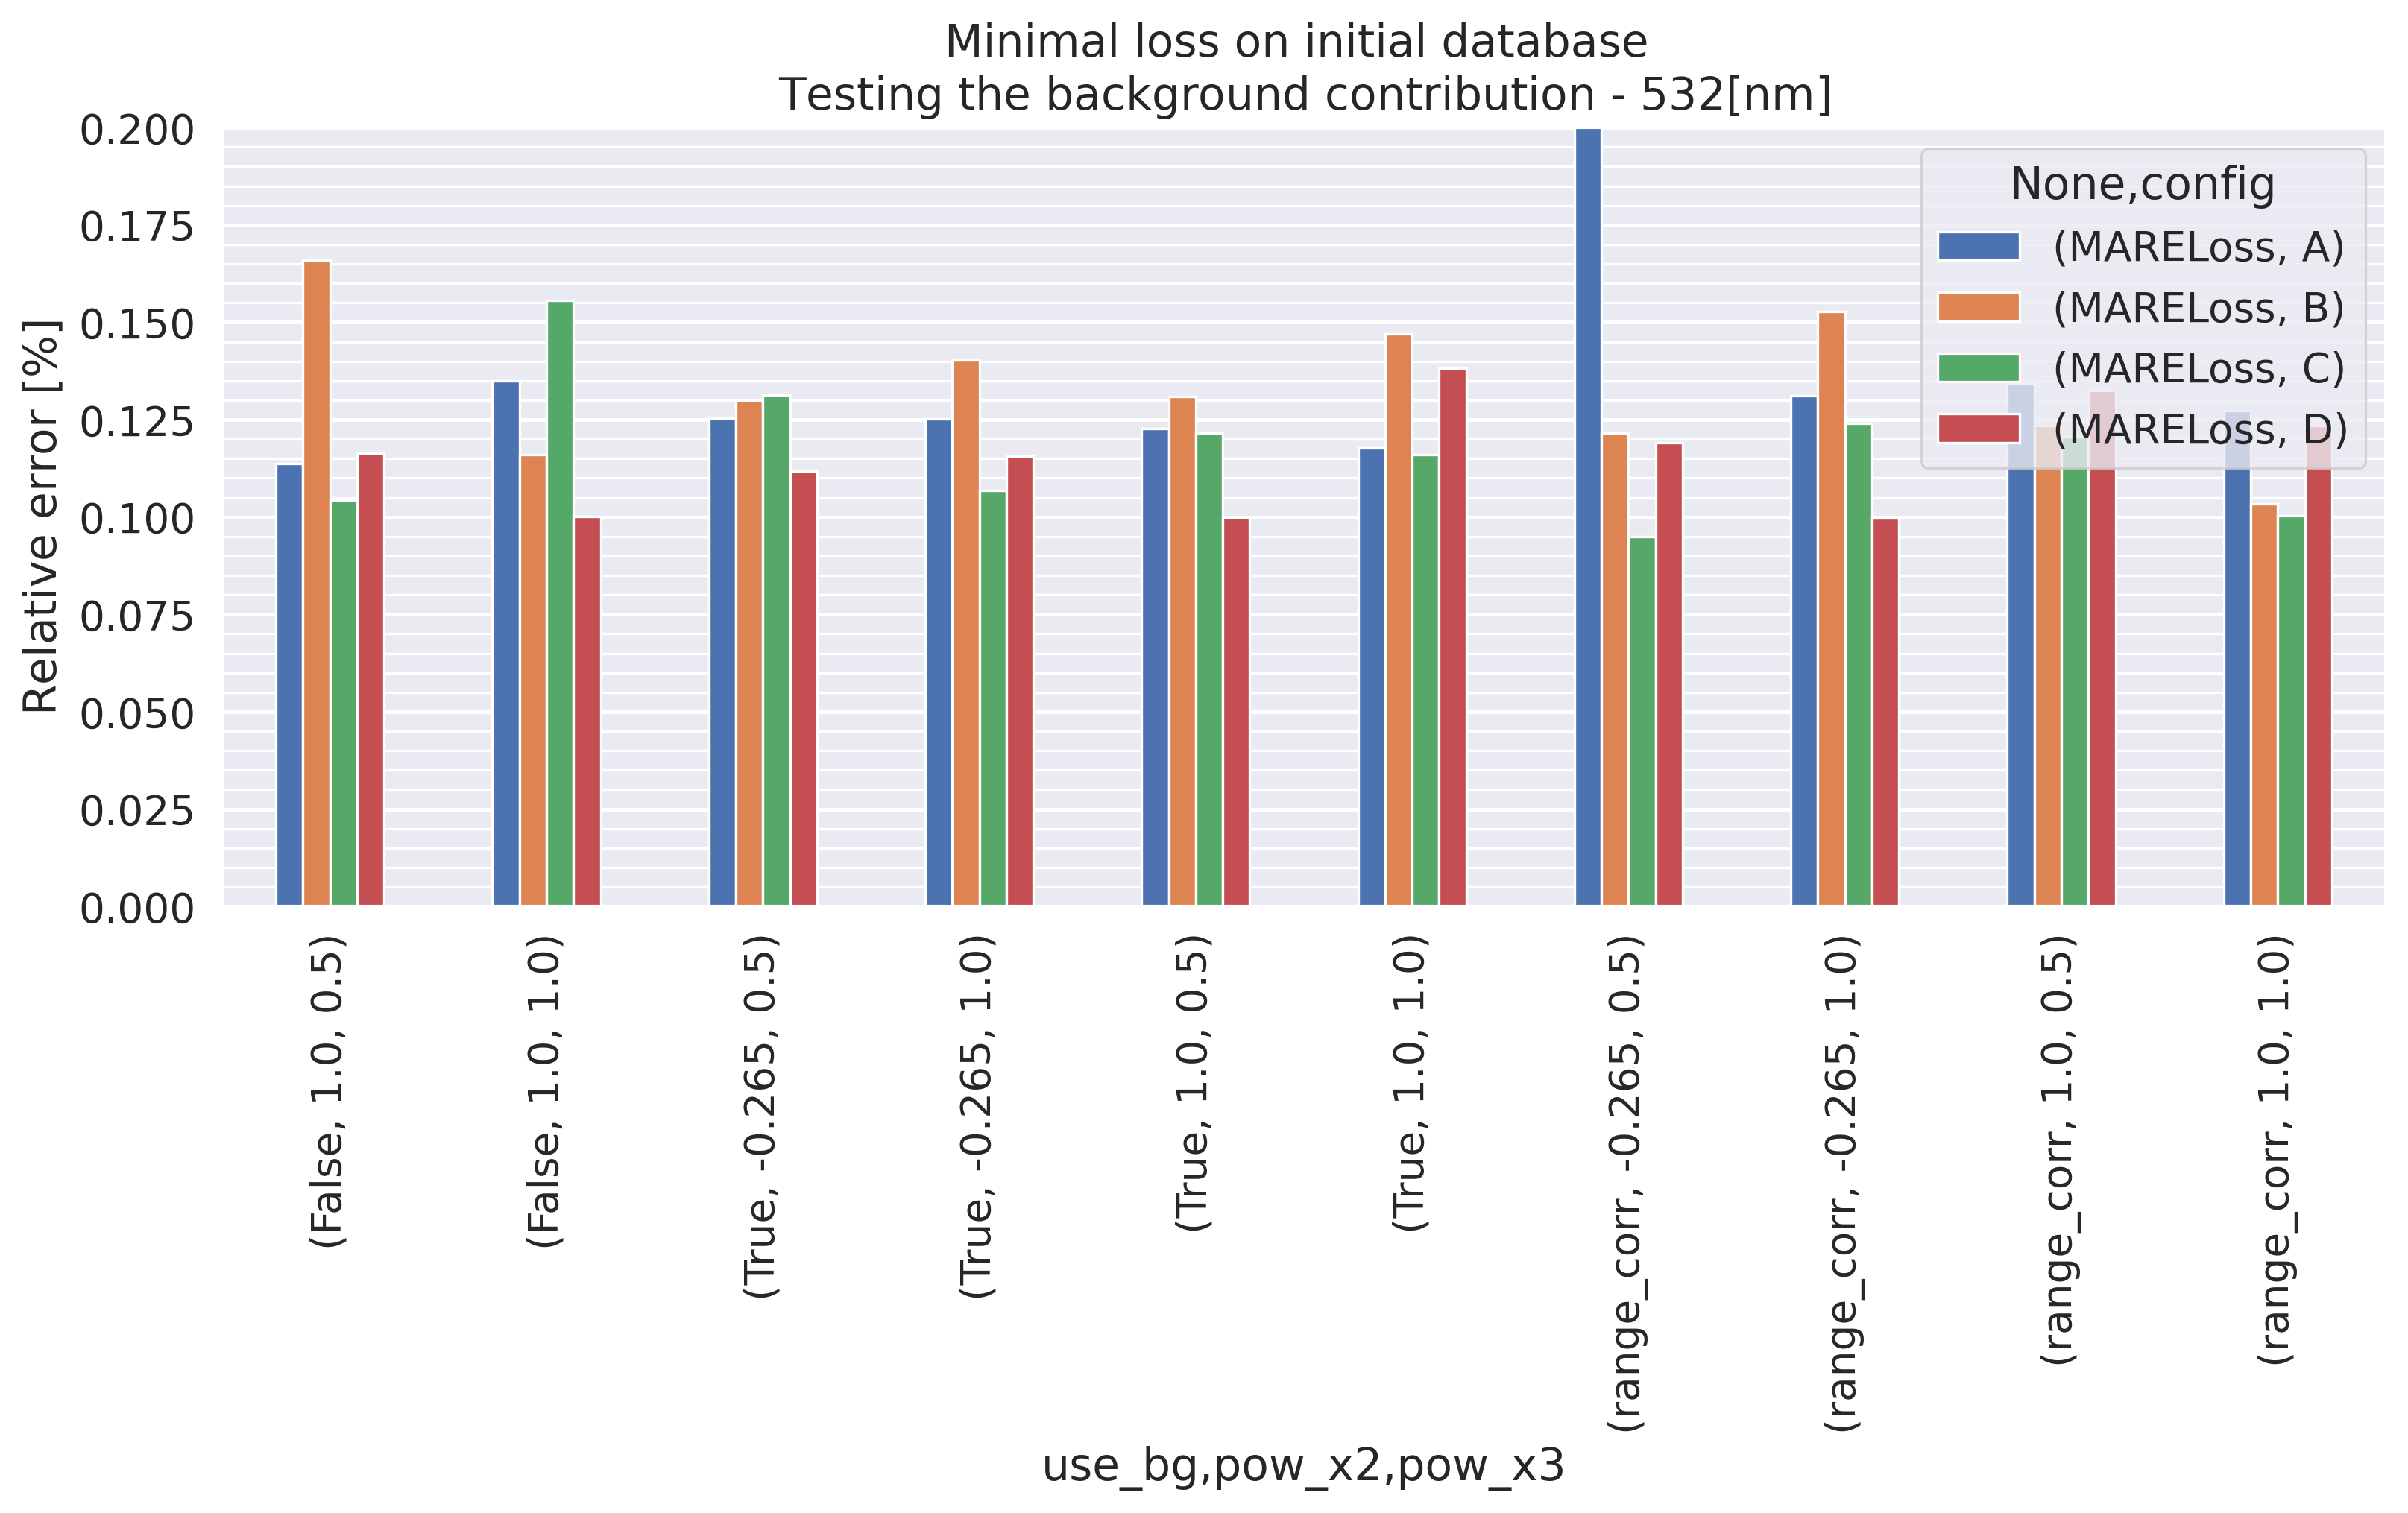

<ipython-input-62-290bd25e3827>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


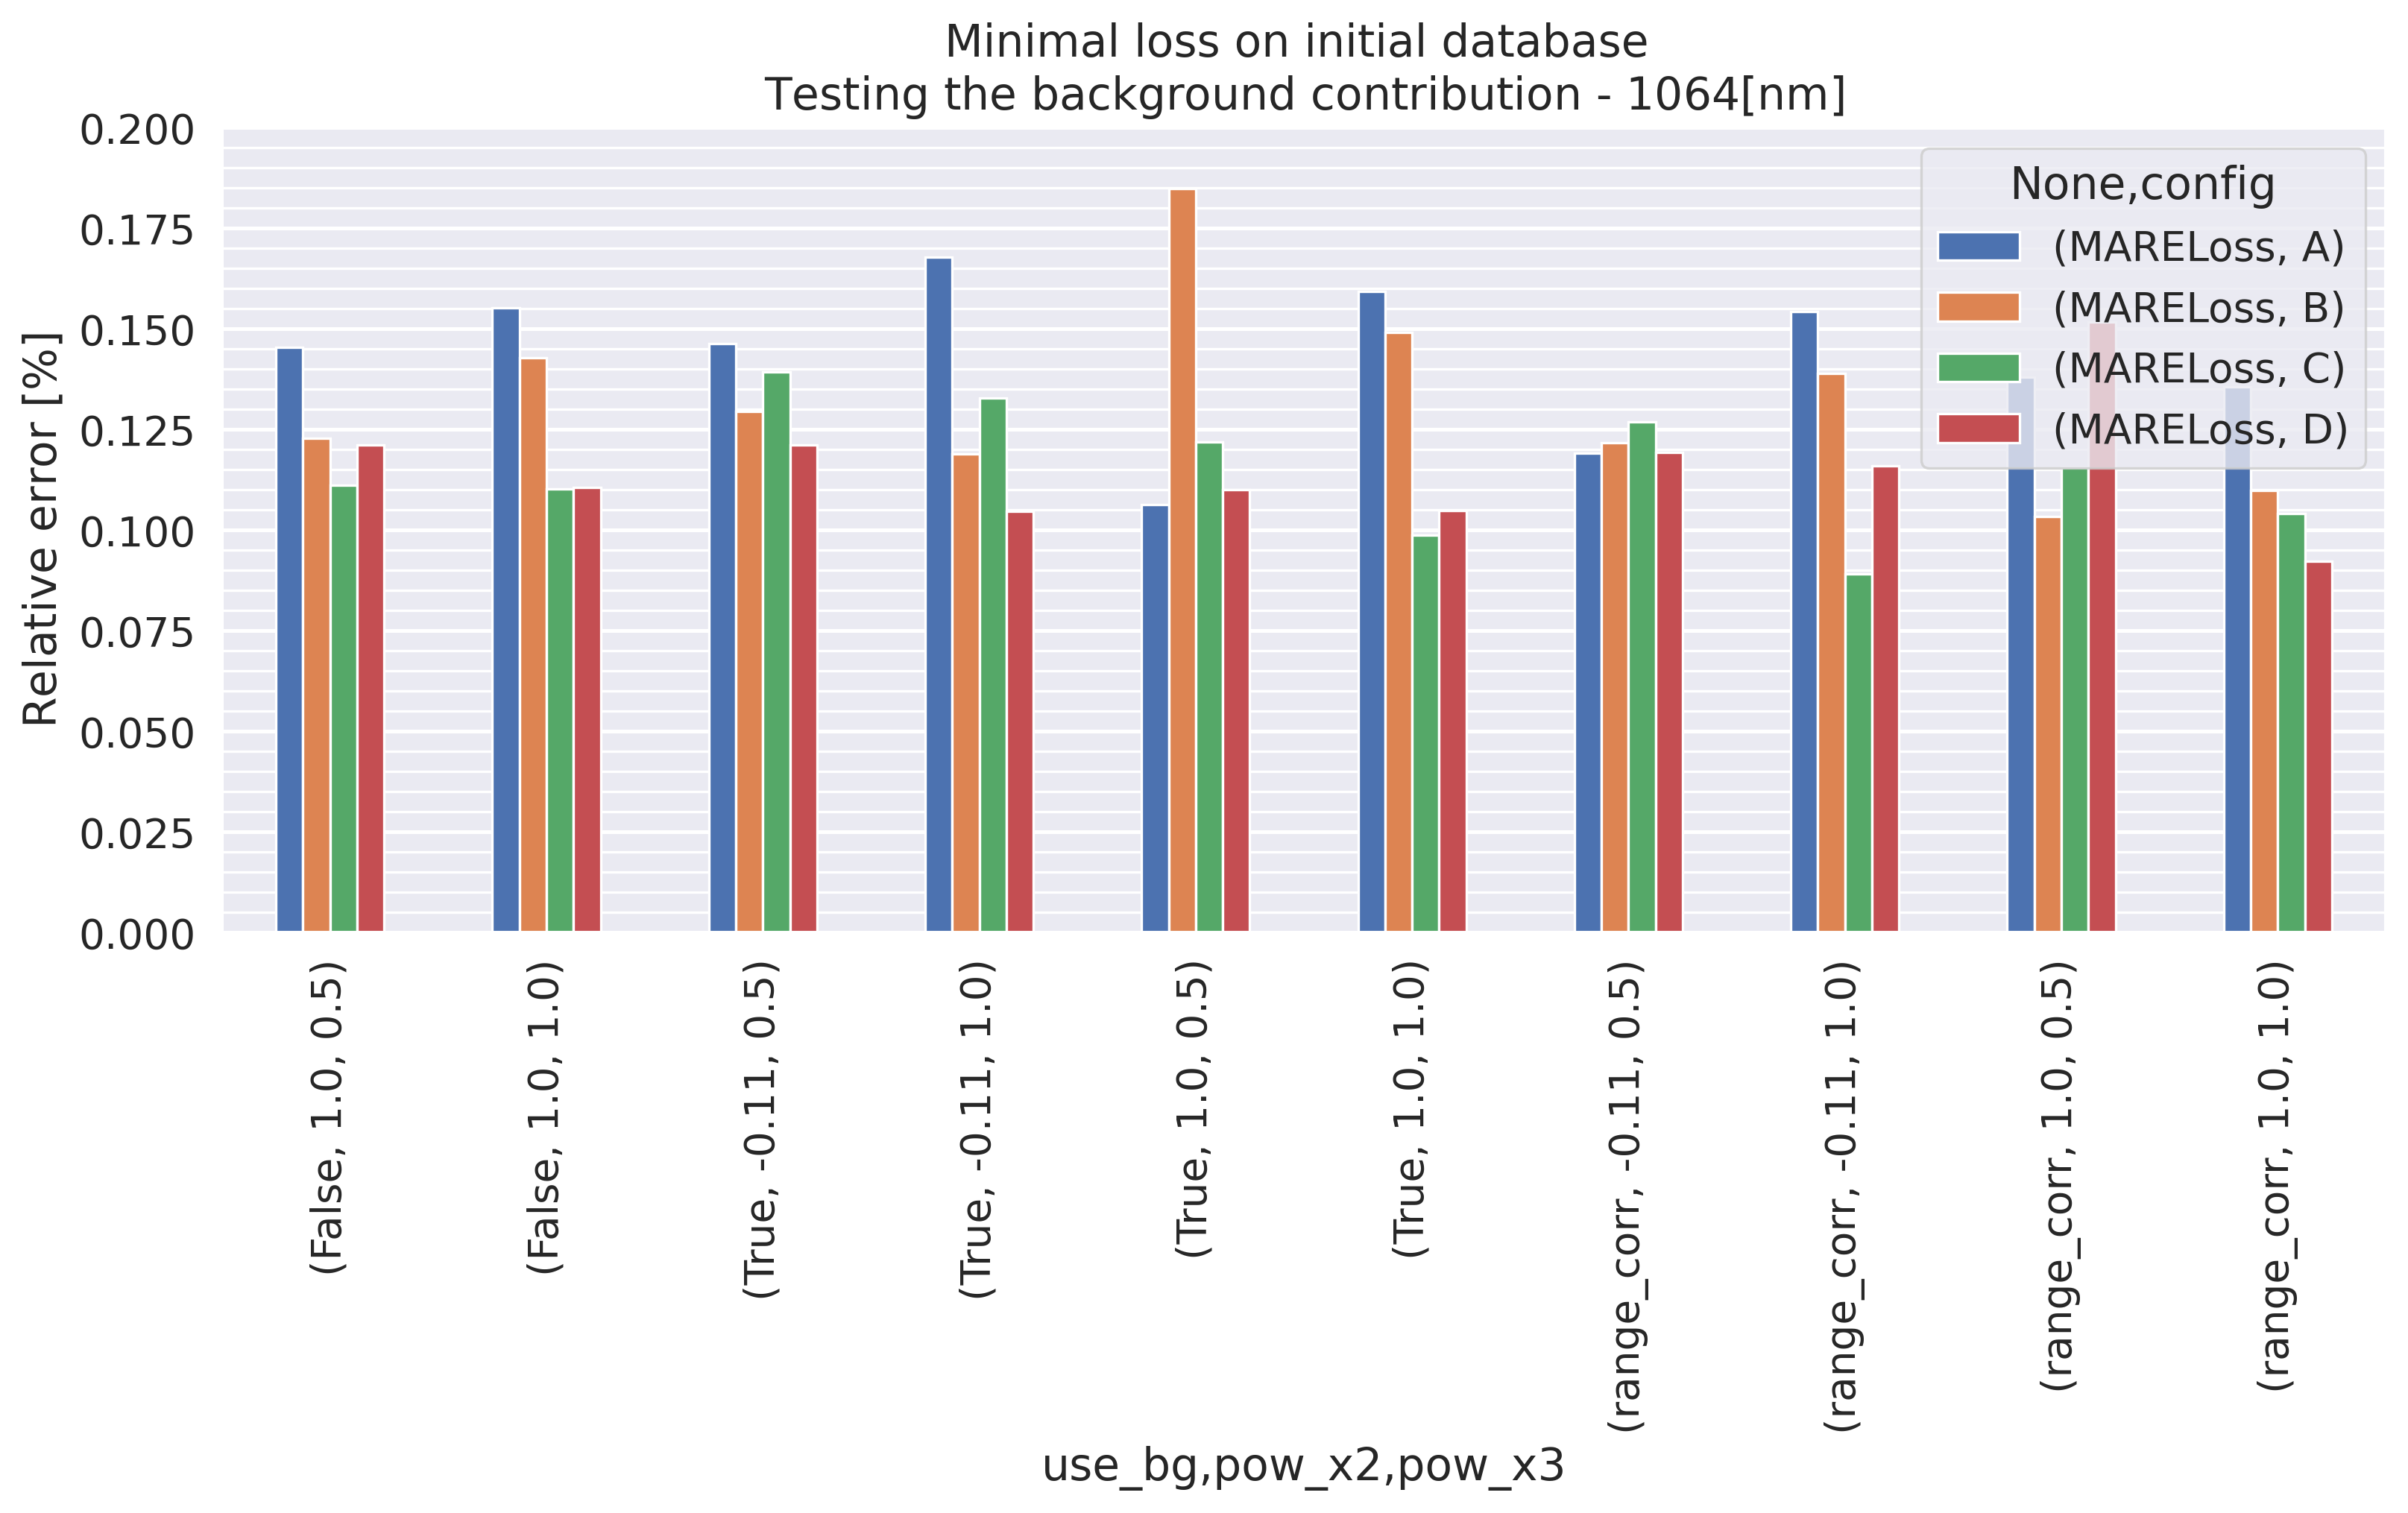

In [62]:
for wavelength in [355,532,1064]:
    p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min)

    plot_pivot_table(p_table, figsize=(11, 7), ylim= [0.0, 0.2],
                     title=f'Minimal loss on initial database \n'+
                           fr'Testing the background contribution - ${wavelength}[\rm nm]$')

In [63]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
               [all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.note=='extended_db']
               [all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Minimal loss on initial database \n Testing the contribution of power transform ')

<ipython-input-63-6ba58dd04916>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]


TypeError: no numeric data to plot

In [ ]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Average loss on the extended database \n Wavelengths separation comparison ')

In [ ]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_power'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Minimal loss on the extended database \n Testing wavelengths separation')

In [ ]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7),
                 title='Minimal loss on extended database \n Searching for an optimal power transform ')

In [ ]:
for wavelength in [355,532,1064]:
    p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['pow_x1','pow_x2','note'],
                   aggfunc=np.mean)

    plot_pivot_table(p_table, figsize=(11, 9),
                     title=f'Minimal loss on extended database \n Testing 1st model - '+
                           fr'${wavelength}[\rm nm]$' )

In [ ]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7),
                 title='Minimal loss on extended database \n Testing the background contribution - separated wavelengths')

In [ ]:
for wavelength in [355,532,1064]:
    p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power]
                   [all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'note'],
                   aggfunc=np.min)

    plot_pivot_table(p_table, figsize=(11, 9), ylim= [0.0, 0.2],
                     title=f'Minimal loss on extended database \n Testing 2nd model - '+
                           fr'${wavelength}[\rm nm]$' )
    

In [ ]:
for wavelength in [355,532,1064]:
    p_table = pd.pivot_table(all_wavs_configABCD
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min)

    plot_pivot_table(p_table, figsize=(11, 7), ylim= [0.0, 0.2],
                     title=f'Minimal loss on extended database \n'+
                           fr'Testing the background contribution - ${wavelength}[\rm nm]$')

In [ ]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==False]
               [all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','note'],#'use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(15, 10),
                 title='Minimal loss on the extended database \n Testing results without power transform')


